# Imports and file details

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style("ticks")

import os
import sys
sys.path.insert(0,'..')

import pandas as pd
import json
import numpy as np

import dask.dataframe as dd
from dask.dataframe.utils import make_meta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

from src_new.utils import SQLParserSchema, PGLastSchema, get_file_encodings, SQLGlotSchema, SimpleDDLParserSchema,TIDBMysqlSchema,JSqlParserSchema

from dask.diagnostics import ProgressBar
ProgressBar().register()

C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\2723619751.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [3]:
def read_partial(parser, schema_type, cols):
    _outdir = '../out_new/'

    if parser == 'sqlparser':
        p = SQLParserSchema()
        _outdir += 'sqlparser'
    elif parser == 'pglast':
        p = PGLastSchema()
        _outdir += 'pglast'
    elif parser == 'sqlglot':
        p = SQLGlotSchema()
        _outdir += 'sqlglot'
    elif parser == 'simple':
        p = SimpleDDLParserSchema()
        _outdir += 'simpleddlparser'
    elif parser == 'tidb':
        p = TIDBMysqlSchema()
        _outdir += 'tidb_mysql'
    elif parser == 'jsqlparser':
        p = JSqlParserSchema()
        _outdir += 'jsqlparser'
    
    if schema_type == 'file':
        _schema = p.file_level_schema
        _outdir += '/'
    elif schema_type == 'stmt':
        _schema = p.statement_list_sch
        _outdir += '_details/'
    
    ddf = dd.read_parquet(_outdir,columns=cols, schema=_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')
    return ddf

In [4]:
# Read file details
fd = []
for file in os.listdir('../out_new/filedetails/'):
        full_filename = "%s/%s" % ('../out_new/filedetails/', file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            for item in dict:
                  fd.append(item)

filedetails_df = pd.DataFrame.from_dict(fd)
del fd

In [5]:
jsql_ddf = read_partial('jsqlparser','file',JSqlParserSchema().file_level_schema.names)
jsql_details_ddf = read_partial('jsqlparser','stmt',JSqlParserSchema().statement_list_sch.names)


# Initial error/match analysis

In [5]:
jsql_ddf.groupby('parsed_file')['file_id'].count().compute()

[########################################] | 100% Completed | 724.36 ms


parsed_file
0    244814
1    113342
Name: file_id, dtype: int64

In [6]:
not_parsed = jsql_ddf[jsql_ddf.parsed_file == 0]

In [1]:
not_parsed = jsql_ddf[jsql_ddf.parsed_file == 0]
not_parsed = not_parsed[not_parsed.file_parse_error.str.contains("CONNECTION_ERROR|",regex=False)]

NameError: name 'jsql_ddf' is not defined

In [8]:
not_parsed['file_id'].count().compute()

[########################################] | 100% Completed | 6.11 ss


22

In [9]:
jsql_ddf[jsql_ddf.file_id == '624313'].head(npartitions=-1)

[########################################] | 100% Completed | 5.25 sms


,file_id,file_path,errors_at_read,num_statements,parsed_file,file_parse_error,file_parse_error_with_brackets,valid_ansi,valid_oracle,valid_mysql,valid_postgres,valid_sqlserver,num_distinct_tables,table_list,num_distinct_columns,column_list,num_distinct_schemas,schema_list,num_distinct_dbs,db_list,view_list,num_constraints,num_ctr_notnull,num_ctr_unique,num_ctr_primary,num_ctr_foreign,counter_str,original,original_highlight,file_comment_count,num_drop_stmt,num_drop_like_stmt,num_create_stmt,num_create_like_stmt,num_insert_stmt,num_insert_like_stmt,num_alter_stmt,num_alter_like_stmt,num_select_stmt,num_view_stmt,num_truncate_stmt,num_update_stmt,num_comment_stmt,num_delete_stmt,num_set_like_stmt,num_execute_like_stmt,num_index_like_stmt,num_transaction_like_stmt
2817,624313,../sqlfiles/624313_character_buffs.sql,0,2,1,None,None,1.0,1.0,1.0,1.0,1.0,1,[CHARACTER_BUFFS],17,"[SPELL_ID, MELEE_RUNE, COUNTERS, PERSISTENT, DOT_RUNE, CASTER_NAME, CASTON_Z, EXTRADICHANCE, CASTER_LEVEL, CASTON_Y, CASTON_X, SLOT_ID, CHARACTER_ID, NUMHITS, TICSREMAINING, MAGIC_RUNE, INSTRUMENT_MOD]",0,None,0,None,None,0,17,0,1,0,None,None,None,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# schema prep
join_schema = pa.schema([])
join_schema = join_schema.append(pa.field("file_id",pa.string()))

# pglast prep

pglast_ddf = read_partial('pglast','file',PGLastSchema().file_level_schema.names)

import ast
pglast_ddf['x'] = pglast_ddf.apply(
    lambda row:
    #'a',
    [] if row['counter_str'] is None else [item for item in ast.literal_eval(row['counter_str'] or 'None') if 'CreateSeqStmt' in item],
    axis=1,
    meta=('x', 'string'))

pglast_ddf['num_create_seq'] = pglast_ddf.apply(
    lambda row:
    row['x'][0]['CreateSeqStmt'] if len(row['x']) > 0 else 0,
    axis=1,
    meta=('num_create_seq', 'float'))

pglast_ddf = pglast_ddf.drop(columns=['x'])  

pglast_ddf['num_tables_without_create_seq'] = pglast_ddf['num_distinct_tables'] - pglast_ddf['num_create_seq']

pglast_ddf['table_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
pglast_ddf['column_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['columns_list'])) if row['columns_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
pglast_ddf['schema_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
pglast_ddf['view_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
pglast_ddf['db_list_str'] = pglast_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

try:
    del dict
except:
    pass
pglast_ddf = pglast_ddf.rename(columns=dict(zip(pglast_ddf.columns, [item.replace("pglast_file_id","file_id") for item in ["pglast_" + item for item in pglast_ddf.columns]])))

for item in PGLastSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("pglast_" + item.name,item.type))
join_schema = join_schema.append(pa.field("pglast_num_create_seq", pa.float64()))
join_schema = join_schema.append(pa.field("pglast_num_tables_without_create_seq", pa.float64()))

join_schema = join_schema.append(pa.field("pglast_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("pglast_db_list_str", pa.string()))

jsql_ddf = read_partial('jsqlparser','file',JSqlParserSchema().file_level_schema.names)


jsql_ddf['table_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['table_list'])) if row['table_list'] is not None else None,
    axis=1,
    meta=('table_list_str', 'string'))
jsql_ddf['column_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['column_list'])) if row['column_list'] is not None else None,
    axis=1,
    meta=('column_list_str', 'string'))
jsql_ddf['schema_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['schema_list'])) if row['schema_list'] is not None else None,
    axis=1,
    meta=('schema_list_str', 'string'))
jsql_ddf['view_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['view_list'])) if row['view_list'] is not None else None,
    axis=1,
    meta=('view_list_str', 'string'))
jsql_ddf['db_list_str'] = jsql_ddf.apply(
    lambda row:
    "|".join(str(x) for x in sorted(row['db_list'])) if row['db_list'] is not None else None,
    axis=1,
    meta=('db_list_str', 'string'))

# renaming cols
jsql_ddf = jsql_ddf.rename(columns=dict(zip(jsql_ddf.columns, [item.replace("jsqlparser_file_id","file_id") for item in ["jsqlparser_" + item for item in jsql_ddf.columns]])))

for item in JSqlParserSchema().file_level_schema:
    if item.name != 'file_id':
        join_schema = join_schema.append(pa.field("jsqlparser_" + item.name,item.type))

join_schema = join_schema.append(pa.field("jsqlparser_table_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsqlparser_column_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsqlparser_schema_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsqlparser_view_list_str", pa.string()))
join_schema = join_schema.append(pa.field("jsqlparser_db_list_str", pa.string()))

pglast_joined_jsql= dd.merge(
    pglast_ddf,
    jsql_ddf,
    on=['file_id'],
    how='inner',indicator=False,suffixes=['_pglast','_jsqlparser'])

In [44]:
parsed_both = pglast_joined_jsql[(pglast_joined_jsql.pglast_parsed_file == 1) & (pglast_joined_jsql.jsqlparser_parsed_file == 1)]

In [45]:
parsed_both['file_id'].count().compute()
# 3163

[########################################] | 100% Completed | 163.97 s
[########################################] | 100% Completed | 164.08 s
[########################################] | 100% Completed | 164.18 s


1631

In [46]:
parsed_both[parsed_both['pglast_num_ctr_foreign'] == parsed_both['jsqlparser_num_ctr_foreign']]['file_id'].count().compute()

[########################################] | 100% Completed | 153.13 s
[########################################] | 100% Completed | 153.23 s
[########################################] | 100% Completed | 153.34 s


1584

In [47]:
parsed_both[parsed_both['pglast_num_distinct_columns'] == parsed_both['jsqlparser_num_distinct_columns']]['file_id'].count().compute()

[########################################] | 100% Completed | 133.34 s
[########################################] | 100% Completed | 133.45 s
[########################################] | 100% Completed | 133.55 s


1602

In [48]:
parsed_both[parsed_both['pglast_num_distinct_tables'] == parsed_both['jsqlparser_num_distinct_tables']]['file_id'].count().compute()

[########################################] | 100% Completed | 130.85 s
[########################################] | 100% Completed | 130.96 s
[########################################] | 100% Completed | 131.07 s


1371

In [49]:
parsed_both[parsed_both['pglast_num_ctr_primary'] == parsed_both['jsqlparser_num_ctr_primary']]['file_id'].count().compute()

[########################################] | 100% Completed | 132.74 s
[########################################] | 100% Completed | 132.75 s
[########################################] | 100% Completed | 132.84 s


1595

In [50]:
parsed_both[parsed_both['pglast_num_ctr_unique'] == parsed_both['jsqlparser_num_ctr_unique']]['file_id'].count().compute()

[########################################] | 100% Completed | 134.57 s
[########################################] | 100% Completed | 134.68 s
[########################################] | 100% Completed | 134.79 s


1617

In [51]:
parsed_both[parsed_both['pglast_num_ctr_notnull'] == parsed_both['jsqlparser_num_ctr_notnull']]['file_id'].count().compute()

[########################################] | 100% Completed | 139.14 s
[########################################] | 100% Completed | 139.25 s
[########################################] | 100% Completed | 139.35 s


1603

In [52]:
investigate = parsed_both[parsed_both['pglast_num_ctr_foreign'] != parsed_both['jsqlparser_num_ctr_foreign']]
investigate = investigate[['file_id','pglast_num_distinct_tables','pglast_table_list','jsqlparser_num_distinct_tables','jsqlparser_table_list','pglast_num_distinct_columns','pglast_columns_list','jsqlparser_num_distinct_columns','jsqlparser_column_list',
'pglast_num_ctr_unique','jsqlparser_num_ctr_unique','pglast_num_ctr_notnull','jsqlparser_num_ctr_notnull','pglast_num_ctr_primary','jsqlparser_num_ctr_primary','pglast_num_ctr_foreign','jsqlparser_num_ctr_foreign']]
investigate.head(npartitions=-1)

[########################################] | 100% Completed | 133.83 s
[########################################] | 100% Completed | 133.93 s
[########################################] | 100% Completed | 134.04 s


,file_id,pglast_num_distinct_tables,pglast_table_list,jsqlparser_num_distinct_tables,jsqlparser_table_list,pglast_num_distinct_columns,pglast_columns_list,jsqlparser_num_distinct_columns,jsqlparser_column_list,pglast_num_ctr_unique,jsqlparser_num_ctr_unique,pglast_num_ctr_notnull,jsqlparser_num_ctr_notnull,pglast_num_ctr_primary,jsqlparser_num_ctr_primary,pglast_num_ctr_foreign,jsqlparser_num_ctr_foreign
5,001917,5.0,"[ESPECIALIDADES, MEDIOS, TIPOS_MEDIO, CIUDADES, PROVINCIAS]",1,[MEDIOS],8.0,"[ID_CIUDAD, ID_PROVINCIA, DIRECCION, ID, ID_ESPECIALIDAD, NOMBRE, DESCRIPCION, ID_TIPO_MEDIO]",3,"[NOMBRE, DIRECCION, ID]",0.0,0,0.0,0,5.0,1,4.0,0
77,005980,3.0,"[CLIENTES, REGIONES, COMUNAS]",1,[CLIENTES],8.0,"[REGION_ID, ID, FECHA_NACIMIENTO, APELLIDO_PATERNO, COMUNA_ID, NOMBRE, EMAIL, APELLIDO_MATERNO]",6,"[EMAIL, ID, APELLIDO_MATERNO, APELLIDO_PATERNO, NOMBRE, FECHA_NACIMIENTO]",0.0,0,8.0,6,3.0,1,2.0,0
32,009205,2.0,"[BANKING_ACCOUNT, USERS]",1,[BANKING_ACCOUNT],6.0,"[USERS_ID, ID, IBAN, TYPE, ACCOUNT_NAME, INSTITUTE_NAME]",6,"[IBAN, ACCOUNT_NAME, ID, INSTITUTE_NAME, USERS_ID, TYPE]",1.0,0,2.0,2,1.0,1,1.0,0
34,008619,2.0,"[PUBLICATION, CTPUBLICATION_TYPE]",1,[PUBLICATION],7.0,"[PUBLICATION_TITLE, PUBLISHED_YEAR, PUBLICATION_REMARKS, IS_PEER_REVIEWED_FG, PUBLICATION_ID, PUBLICATION_LOC, PUBLICATION_TYPE]",7,"[PUBLICATION_LOC, PUBLISHED_YEAR, IS_PEER_REVIEWED_FG, PUBLICATION_REMARKS, PUBLICATION_TYPE, PUBLICATION_ID, PUBLICATION_TITLE]",0.0,0,4.0,4,1.0,1,1.0,0
65,004305,12.0,"[DEPOSIT_TRANS, COMPANY, LOCATION, CUSTOMER, USER, ADMINISTRATOR, PORTFOLIO_ACTION, TRANSACTION, OWNS, MUTUALFUND, PREFERS, CLOSING_PRICE]",12,"[PREFERS, LOCATION, PORTFOLIO_ACTION, CLOSING_PRICE, COMPANY, DEPOSIT_TRANS, USER, TRANSACTION, CUSTOMER, MUTUALFUND, ADMINISTRATOR, OWNS]",27.0,"[CITY, C_DATE, P_DATE, NAME, ADDRESS, CATEGORY, DESCRIPTION, ACTION, T_DATE, NUM_SHARES, POSTCODE, STATE, SYMBOL, EMAIL, TRANS_ID, PRICE, LOGIN, BALANCE, LOCATION, PASSWORD, COMPANY_ID, SHARES, PERCENTAGE, CEO_FNAME, T_NUM_SHARES, AMOUNT, CEO_LNAME]",27,"[LOGIN, POSTCODE, ACTION, SYMBOL, LOCATION, NAME, NUM_SHARES, AMOUNT, ADDRESS, PASSWORD, P_DATE, DESCRIPTION, SHARES, BALANCE, C_DATE, PERCENTAGE, T_NUM_SHARES, EMAIL, TRANS_ID, COMPANY_ID, PRICE, CEO_LNAME, STATE, T_DATE, CEO_FNAME, CATEGORY, CITY]",1.0,1,9.0,9,12.0,11,14.0,13


In [53]:
investigate = parsed_both[parsed_both['pglast_num_ctr_primary'] != parsed_both['jsqlparser_num_ctr_primary']]
investigate = investigate[['file_id','pglast_num_distinct_tables','pglast_table_list','jsqlparser_num_distinct_tables','jsqlparser_table_list','pglast_num_distinct_columns','pglast_columns_list','jsqlparser_num_distinct_columns','jsqlparser_column_list',
'pglast_num_ctr_unique','jsqlparser_num_ctr_unique','pglast_num_ctr_notnull','jsqlparser_num_ctr_notnull','pglast_num_ctr_primary','jsqlparser_num_ctr_primary','pglast_num_ctr_foreign','jsqlparser_num_ctr_foreign']]
investigate.head(npartitions=-1)

[########################################] | 100% Completed | 128.17 s
[########################################] | 100% Completed | 128.28 s
[########################################] | 100% Completed | 128.38 s


,file_id,pglast_num_distinct_tables,pglast_table_list,jsqlparser_num_distinct_tables,jsqlparser_table_list,pglast_num_distinct_columns,pglast_columns_list,jsqlparser_num_distinct_columns,jsqlparser_column_list,pglast_num_ctr_unique,jsqlparser_num_ctr_unique,pglast_num_ctr_notnull,jsqlparser_num_ctr_notnull,pglast_num_ctr_primary,jsqlparser_num_ctr_primary,pglast_num_ctr_foreign,jsqlparser_num_ctr_foreign
5,001917,5.0,"[ESPECIALIDADES, MEDIOS, TIPOS_MEDIO, CIUDADES, PROVINCIAS]",1,[MEDIOS],8.0,"[ID_CIUDAD, ID_PROVINCIA, DIRECCION, ID, ID_ESPECIALIDAD, NOMBRE, DESCRIPCION, ID_TIPO_MEDIO]",3,"[NOMBRE, DIRECCION, ID]",0.0,0,0.0,0,5.0,1,4.0,0
100,005980,3.0,"[CLIENTES, REGIONES, COMUNAS]",1,[CLIENTES],8.0,"[REGION_ID, ID, FECHA_NACIMIENTO, APELLIDO_PATERNO, COMUNA_ID, NOMBRE, EMAIL, APELLIDO_MATERNO]",6,"[EMAIL, ID, APELLIDO_MATERNO, APELLIDO_PATERNO, NOMBRE, FECHA_NACIMIENTO]",0.0,0,8.0,6,3.0,1,2.0,0
95,004305,12.0,"[DEPOSIT_TRANS, COMPANY, LOCATION, CUSTOMER, USER, ADMINISTRATOR, PORTFOLIO_ACTION, TRANSACTION, OWNS, MUTUALFUND, PREFERS, CLOSING_PRICE]",12,"[PREFERS, LOCATION, PORTFOLIO_ACTION, CLOSING_PRICE, COMPANY, DEPOSIT_TRANS, USER, TRANSACTION, CUSTOMER, MUTUALFUND, ADMINISTRATOR, OWNS]",27.0,"[CITY, C_DATE, P_DATE, NAME, ADDRESS, CATEGORY, DESCRIPTION, ACTION, T_DATE, NUM_SHARES, POSTCODE, STATE, SYMBOL, EMAIL, TRANS_ID, PRICE, LOGIN, BALANCE, LOCATION, PASSWORD, COMPANY_ID, SHARES, PERCENTAGE, CEO_FNAME, T_NUM_SHARES, AMOUNT, CEO_LNAME]",27,"[LOGIN, POSTCODE, ACTION, SYMBOL, LOCATION, NAME, NUM_SHARES, AMOUNT, ADDRESS, PASSWORD, P_DATE, DESCRIPTION, SHARES, BALANCE, C_DATE, PERCENTAGE, T_NUM_SHARES, EMAIL, TRANS_ID, COMPANY_ID, PRICE, CEO_LNAME, STATE, T_DATE, CEO_FNAME, CATEGORY, CITY]",1.0,1,9.0,9,12.0,11,14.0,13
74,014216,14.0,"[AGE_GROUP, REGLAMENT_GROUP_LIST, FILE, REGLAMENT, PARTICIPANT, USER, FIGHTS, SPORT_TYPE, COACH, TEAM, TOURNAMENT_PARTICIPANT, TOURNAMENT, GROUPS, TOURNAMENT_COACH]",1,[AGE_GROUP],44.0,"[TEAM_ID, NAME, PARTICIPANT_ID, ID, RANK, SPORT_TYPE_ID, WEIGHT, PARTICIPANTS_LIMIT, BIRTH_DATE, FIGHT_NUMBER, GROUP_ID, DELETED_BY, VIEW, ENABLED, SECOND_PARTICIPANT_ID, TOURNAMENT_ID, AGE_GROUP_ID, ROLES, GENDER, EMAIL, USER_ID, JUDGE, FIRST_NAME, RATING, WINNER_PARTICIPANT_ID, CREATED_BY, PARENT_SPORT_TYPE_ID, LAST_NAME, RAITING, PASSWORD, FIGHT_ROUND, UPDATED_BY, TOURNAMENT_DATE_END, TOURNAMENT_DATE_START, REGION, UPDATED_AT, DELETED_AT, AGE, AGE_GROUP, CREATED_AT, REGLAMENT_ID, USERNAME, COACH_ID, FIRST_PARTICIPANT_ID]",8,"[CREATED_AT, DELETED_BY, CREATED_BY, UPDATED_BY, ID, AGE_GROUP, UPDATED_AT, DELETED_AT]",0.0,0,7.0,0,13.0,1,18.0,0
46,011561,2.0,"[MESSAGE, QUEUE]",1,[QUEUE],8.0,"[TIMEOUT, BODY, QUEUE_ID, QUEUE_NAME, CREATED, MESSAGE_ID, MD5, HANDLE]",3,"[QUEUE_NAME, QUEUE_ID, TIMEOUT]",0.0,0,6.0,3,2.0,1,1.0,0


In [54]:
investigate = parsed_both[parsed_both['pglast_num_ctr_notnull'] != parsed_both['jsqlparser_num_ctr_notnull']]
investigate = investigate[['file_id','pglast_num_distinct_tables','pglast_table_list','jsqlparser_num_distinct_tables','jsqlparser_table_list','pglast_num_distinct_columns','pglast_columns_list','jsqlparser_num_distinct_columns','jsqlparser_column_list',
'pglast_num_ctr_unique','jsqlparser_num_ctr_unique','pglast_num_ctr_notnull','jsqlparser_num_ctr_notnull','pglast_num_ctr_primary','jsqlparser_num_ctr_primary','pglast_num_ctr_foreign','jsqlparser_num_ctr_foreign']]
investigate.head(npartitions=-1)

[########################################] | 100% Completed | 129.37 s
[########################################] | 100% Completed | 129.48 s
[########################################] | 100% Completed | 129.58 s


,file_id,pglast_num_distinct_tables,pglast_table_list,jsqlparser_num_distinct_tables,jsqlparser_table_list,pglast_num_distinct_columns,pglast_columns_list,jsqlparser_num_distinct_columns,jsqlparser_column_list,pglast_num_ctr_unique,jsqlparser_num_ctr_unique,pglast_num_ctr_notnull,jsqlparser_num_ctr_notnull,pglast_num_ctr_primary,jsqlparser_num_ctr_primary,pglast_num_ctr_foreign,jsqlparser_num_ctr_foreign
46,005980,3.0,"[CLIENTES, REGIONES, COMUNAS]",1,[CLIENTES],8.0,"[REGION_ID, ID, FECHA_NACIMIENTO, APELLIDO_PATERNO, COMUNA_ID, NOMBRE, EMAIL, APELLIDO_MATERNO]",6,"[EMAIL, ID, APELLIDO_MATERNO, APELLIDO_PATERNO, NOMBRE, FECHA_NACIMIENTO]",0.0,0,8.0,6,3.0,1,2.0,0
41,006566,2.0,"[STATE, ADDRESS]",2,"[STATE, ADDRESS]",0.0,None,0,None,0.0,0,0.0,1,1.0,1,1.0,1
28,005036,13.0,"[CATEGORIES, USERS, COUPON, PRODUCTS, AUTHOR, SUBCATEGORY, USER_ROLE, ORDER_CART, PRODUCT_PHOTO, ORDER_DETAILS, DELIVERY_COMPANY, ROLES, PAYMENT]",13,"[ROLES, DELIVERY_COMPANY, COUPON, USER_ROLE, PRODUCT_PHOTO, PRODUCTS, USERS, PAYMENT, CATEGORIES, ORDER_CART, SUBCATEGORY, AUTHOR, ORDER_DETAILS]",31.0,"[SUBCATEGORY_ID, CITY, NAME, ADDRESS, AUTHOR_ID, ROLE_ID, DESCRIPTION, URL, DATE_FROM, CATEGORY_NAME, EMAIL, USER_ID, FIRST_NAME, QUANTITY, PASSWORDS, PRICE, PHOTO_ID, COMPANY, PRODUCT_ID, LOGIN, LAST_NAME, ORDER_STATUS, NUMBERS_OF_DAY, CARD_NUMBER, TOTAL_PRICE, SALES, CODE, ORDER_CART_ID, CATEGORY_ID, PAYMENT_ID, AUTHOR_NAME]",31,"[LOGIN, NAME, COMPANY, AUTHOR_ID, ORDER_CART_ID, ADDRESS, PHOTO_ID, TOTAL_PRICE, ORDER_STATUS, SALES, FIRST_NAME, USER_ID, DESCRIPTION, NUMBERS_OF_DAY, DATE_FROM, PAYMENT_ID, EMAIL, CODE, PRODUCT_ID, PRICE, CARD_NUMBER, CATEGORY_NAME, AUTHOR_NAME, SUBCATEGORY_ID, QUANTITY, LAST_NAME, URL, CATEGORY_ID, PASSWORDS, ROLE_ID, CITY]",0.0,0,14.0,15,11.0,11,12.0,12
74,010896,14.0,"[ACT_RU_METER_LOG, ACT_RU_JOBDEF, ACT_HI_DECINST, ACT_RU_EXECUTION, ACT_RE_DECISION_DEF, ACT_HI_DEC_OUT, ACT_HI_OP_LOG, ACT_HI_DEC_IN, ACT_RU_AUTHORIZATION, ACT_RU_CASE_SENTRY_PART, ACT_RU_EXT_TASK, ACT_RE_DEPLOYMENT, ACT_HI_JOB_LOG, ACT_RU_JOB]",14,"[ACT_RU_JOBDEF, ACT_HI_DEC_OUT, ACT_RU_METER_LOG, ACT_RU_EXECUTION, ACT_RU_JOB, ACT_RU_EXT_TASK, ACT_RU_CASE_SENTRY_PART, ACT_RE_DEPLOYMENT, ACT_HI_DECINST, ACT_RE_DECISION_DEF, ACT_HI_OP_LOG, ACT_HI_JOB_LOG, ACT_RU_AUTHORIZATION, ACT_HI_DEC_IN]",45.0,"[TEXT_, DEC_DEF_ID_, CASE_INST_ID_, DEC_DEF_KEY_, SOURCE_, DEC_DEF_NAME_, CASE_DEF_ID_, ID_, WORKER_ID_, EVAL_TIME_, KEY_, TEXT2_, CATEGORY_, PROC_DEF_ID_, CLAUSE_NAME_, CASE_DEF_KEY_, ERROR_MSG_, REPORTER_, NAME_, BYTEARRAY_ID_, ACT_ID_, SUSPENSION_STATE_, DOUBLE_, RULE_ORDER_, RETRIES_, DGRM_RESOURCE_NAME_, COLLECT_VALUE_, DEC_INST_ID_, CLAUSE_ID_, RESOURCE_NAME_, PRIORITY_, PROC_INST_ID_, REV_, ACT_INST_ID_, VAR_TYPE_, JOB_PRIORITY_, RULE_ID_, VAR_NAME_, VERSION_, PROC_DEF_KEY_, TOPIC_NAME_, LOCK_EXP_TIME_, LONG_, EXECUTION_ID_, DEPLOYMENT_ID_]",45,"[ERROR_MSG_, RESOURCE_NAME_, EXECUTION_ID_, LONG_, TOPIC_NAME_, BYTEARRAY_ID_, DOUBLE_, REPORTER_, DEC_DEF_KEY_, DEC_DEF_ID_, SUSPENSION_STATE_, PROC_INST_ID_, RETRIES_, CASE_INST_ID_, DEC_DEF_NAME_, ACT_INST_ID_, TEXT2_, PROC_DEF_KEY_, CASE_DEF_KEY_, COLLECT_VALUE_, CLAUSE_NAME_, VAR_NAME_, TEXT_, PRIORITY_, JOB_PRIORITY_, EVAL_TIME_, CATEGORY_, VERSION_, ID_, CLAUSE_ID_, WORKER_ID_, DEPLOYMENT_ID_, ACT_ID_, KEY_, RULE_ID_, RULE_ORDER_, VAR_TYPE_, LOCK_EXP_TIME_, DGRM_RESOURCE_NAME_, SOURCE_, REV_, CASE_DEF_ID_, DEC_INST_ID_, NAME_, PROC_DEF_ID_]",1.0,1,18.0,19,5.0,5,1.0,1
93,014216,14.0,"[AGE_GROUP, REGLAMENT_GROUP_LIST, FILE, REGLAMENT, PARTICIPANT, USER, FIGHTS, SPORT_TYPE, COACH, TEAM, TOURNAMENT_PARTICIPANT, TOURNAMENT, GROUPS, TOURNAMENT_COACH]",1,[AGE_GROUP],44.0,"[TEAM_ID, NAME, PARTICIPANT_ID, ID, RANK, SPORT_TYPE_ID, WEIGHT, PARTICIPANTS_LIMIT, BIRTH_DATE, FIGHT_NUMBER, GROUP_ID, DELETED_BY, VIEW, ENABLED, SECOND_PARTICIPANT_ID, TOURNAMENT_ID, AGE_GROUP_ID, ROLES, GENDER, EMAIL, USER_ID, JUDGE, FIRST_NAME, RATING, WINNER_PARTICIPANT_ID, CREATED_BY, PARENT_SPORT_TYPE_ID, LAST_NAME, RAITING, PASSWORD, FIGHT_ROUND, U

In [55]:
investigate = parsed_both[parsed_both['pglast_num_ctr_unique'] != parsed_both['jsqlparser_num_ctr_unique']]
investigate = investigate[['file_id','pglast_num_distinct_tables','pglast_table_list','jsqlparser_num_distinct_tables','jsqlparser_table_list','pglast_num_distinct_columns','pglast_columns_list','jsqlparser_num_distinct_columns','jsqlparser_column_list',
'pglast_num_ctr_unique','jsqlparser_num_ctr_unique','pglast_num_ctr_notnull','jsqlparser_num_ctr_notnull','pglast_num_ctr_primary','jsqlparser_num_ctr_primary','pglast_num_ctr_foreign','jsqlparser_num_ctr_foreign']]
investigate.head(npartitions=-1)

[########################################] | 100% Completed | 126.77 s
[########################################] | 100% Completed | 126.87 s
[########################################] | 100% Completed | 126.98 s


,file_id,pglast_num_distinct_tables,pglast_table_list,jsqlparser_num_distinct_tables,jsqlparser_table_list,pglast_num_distinct_columns,pglast_columns_list,jsqlparser_num_distinct_columns,jsqlparser_column_list,pglast_num_ctr_unique,jsqlparser_num_ctr_unique,pglast_num_ctr_notnull,jsqlparser_num_ctr_notnull,pglast_num_ctr_primary,jsqlparser_num_ctr_primary,pglast_num_ctr_foreign,jsqlparser_num_ctr_foreign
80,009205,2.0,"[BANKING_ACCOUNT, USERS]",1,[BANKING_ACCOUNT],6.0,"[USERS_ID, ID, IBAN, TYPE, ACCOUNT_NAME, INSTITUTE_NAME]",6,"[IBAN, ACCOUNT_NAME, ID, INSTITUTE_NAME, USERS_ID, TYPE]",1.0,0,2.0,2,1.0,1,1.0,0
4,000222,6.0,"[PARTICIPA, TRAMO, COCHE, PILOTO, CORRE, RALLY]",6,"[TRAMO, COCHE, CORRE, PARTICIPA, RALLY, PILOTO]",21.0,"[NOMBREP, CODRALLY, PENALIZACION, NOMBRE, RH, CODPILOTO, MODELO, CODCOCHE, PIS, FECHA, NOMBRECOP, NUMEROTRAMO, GRUPOS, DIFICULTAD, TIEMPO, CILINDRADA, MARCA, COCHE, TOTALKMS, TIEMPORALLY, PUNTOS]",21,"[PUNTOS, CODPILOTO, FECHA, NOMBRECOP, MODELO, CODCOCHE, MARCA, NOMBREP, TOTALKMS, TIEMPORALLY, TIEMPO, NUMEROTRAMO, RH, GRUPOS, NOMBRE, CILINDRADA, COCHE, CODRALLY, DIFICULTAD, PENALIZACION, PIS]",5.0,4,7.0,7,6.0,6,6.0,6
58,012451,12.0,"[PLACE, PLAT_INGREDIENTS, PLAT, STAT_CHIFFRE_AFFAIRE, INGREDIENT, LIGNE_COMMANDE, STAT_GENERAL, UNITE, ROLE, COMPTE, CATEGORIE, COMMANDE]",12,"[LIGNE_COMMANDE, INGREDIENT, PLAT_INGREDIENTS, UNITE, CATEGORIE, ROLE, STAT_GENERAL, COMPTE, PLACE, COMMANDE, STAT_CHIFFRE_AFFAIRE, PLAT]",32.0,"[NOM_RESERVATION, ID, ACTIF, ID_COMPTE_SERVEUR, NB_COMMANDES_PREPAREES, ID_PLAT, PRENOM_RESERVATION, ID_PLACE, PRENOM, ID_ROLE, CHIFFRE_AFFAIRE_DEJEUNER, CARTE, ID_CATEGORIE, DATETIME_CREATION, TEMPS_PREPARATION, CHIFFRE_AFFAIRE_DINER, DATE_JOUR, ETAT, QUANTITE, NB_COMMANDES_PAYEES, LIBELLE, COUT_TOTAL, NB_CLIENTS, ID_INGREDIENT, NB_OCCURENCES, NOM, DATETIME_RESERVATION, PRIX, ID_COMMANDE, ID_UNITE, CHIFFRE_AFFAIRE, STOCK]",32,"[STOCK, PRIX, COUT_TOTAL, NB_OCCURENCES, NB_CLIENTS, ID_UNITE, CARTE, ACTIF, DATETIME_CREATION, ID_COMPTE_SERVEUR, CHIFFRE_AFFAIRE_DEJEUNER, QUANTITE, ETAT, DATETIME_RESERVATION, LIBELLE, CHIFFRE_AFFAIRE, CHIFFRE_AFFAIRE_DINER, NB_COMMANDES_PREPAREES, ID_INGREDIENT, TEMPS_PREPARATION, PRENOM, ID_PLACE, ID_COMMANDE, NOM_RESERVATION, DATE_JOUR, NB_COMMANDES_PAYEES, ID_CATEGORIE, PRENOM_RESERVATION, ID_ROLE, NOM, ID_PLAT, ID]",2.0,0,40.0,40,12.0,12,10.0,2
57,006533,2.0,"[WORKFLOWS, WORKFLOW_PHASES]",1,[WORKFLOWS],11.0,"[UUID, VERSION, CREATED_AT, WORKFLOW_ID, NAME, ID, ACTIVE, DESCRIPTION, MODIFIED_BY, MODIFIED_AT, CREATED_BY]",10,"[CREATED_BY, ACTIVE, DESCRIPTION, CREATED_AT, NAME, MODIFIED_BY, ID, UUID, VERSION, MODIFIED_AT]",2.0,0,13.0,7,2.0,1,1.0,0
76,012598,3.0,"[USERS, ROLES, USER_AUTH_TOKENS]",1,[USERS],24.0,"[ROLE_ID, ID, STATUS, SALT, FAILED_LOGIN_COUNT, MODIFIED_BY, EMAIL, FIRST_NAME, USER_ID, SUBSCRIPTIONS_CONSENT, LAST_PASSWORD_CHANGE_AT, LOGOUT_AT, PASSWORD, LAST_NAME, LOGIN_AT, ACCESS_TOKEN, UUID, VERSION, CREATED_AT, MOBILE_PHONE, EXPIRES_AT, MODIFIED_AT, CREATED_BY, LAST_LOGIN_AT]",19,"[LAST_NAME, CREATED_AT, MOBILE_PHONE, EMAIL, UUID, SUBSCRIPTIONS_CONSENT, MODIFIED_BY, FAILED_LOGIN_COUNT, LAST_PASSWORD_CHANGE_AT, VERSION, SALT, STATUS, LAST_LOGIN_AT, CREATED_BY, PASSWORD, FIRST_NAME, MODIFIED_AT, ROLE_ID, ID]",2.0,0,18.0,11,2.0,1,2.0,0


In [56]:
investigate = parsed_both[parsed_both['pglast_num_distinct_columns'] != parsed_both['jsqlparser_num_distinct_columns']]
investigate = investigate[['file_id','pglast_num_distinct_tables','pglast_table_list','jsqlparser_num_distinct_tables','jsqlparser_table_list','pglast_num_distinct_columns','pglast_columns_list','jsqlparser_num_distinct_columns','jsqlparser_column_list',
'pglast_num_ctr_unique','jsqlparser_num_ctr_unique','pglast_num_ctr_notnull','jsqlparser_num_ctr_notnull','pglast_num_ctr_primary','jsqlparser_num_ctr_primary','pglast_num_ctr_foreign','jsqlparser_num_ctr_foreign']]
investigate.head(npartitions=-1)

[########################################] | 100% Completed | 127.39 s
[########################################] | 100% Completed | 127.50 s
[########################################] | 100% Completed | 127.60 s


,file_id,pglast_num_distinct_tables,pglast_table_list,jsqlparser_num_distinct_tables,jsqlparser_table_list,pglast_num_distinct_columns,pglast_columns_list,jsqlparser_num_distinct_columns,jsqlparser_column_list,pglast_num_ctr_unique,jsqlparser_num_ctr_unique,pglast_num_ctr_notnull,jsqlparser_num_ctr_notnull,pglast_num_ctr_primary,jsqlparser_num_ctr_primary,pglast_num_ctr_foreign,jsqlparser_num_ctr_foreign
5,001917,5.0,"[ESPECIALIDADES, MEDIOS, TIPOS_MEDIO, CIUDADES, PROVINCIAS]",1,[MEDIOS],8.0,"[ID_CIUDAD, ID_PROVINCIA, DIRECCION, ID, ID_ESPECIALIDAD, NOMBRE, DESCRIPCION, ID_TIPO_MEDIO]",3,"[NOMBRE, DIRECCION, ID]",0.0,0,0.0,0,5.0,1,4.0,0
46,005980,3.0,"[CLIENTES, REGIONES, COMUNAS]",1,[CLIENTES],8.0,"[REGION_ID, ID, FECHA_NACIMIENTO, APELLIDO_PATERNO, COMUNA_ID, NOMBRE, EMAIL, APELLIDO_MATERNO]",6,"[EMAIL, ID, APELLIDO_MATERNO, APELLIDO_PATERNO, NOMBRE, FECHA_NACIMIENTO]",0.0,0,8.0,6,3.0,1,2.0,0
93,014216,14.0,"[AGE_GROUP, REGLAMENT_GROUP_LIST, FILE, REGLAMENT, PARTICIPANT, USER, FIGHTS, SPORT_TYPE, COACH, TEAM, TOURNAMENT_PARTICIPANT, TOURNAMENT, GROUPS, TOURNAMENT_COACH]",1,[AGE_GROUP],44.0,"[TEAM_ID, NAME, PARTICIPANT_ID, ID, RANK, SPORT_TYPE_ID, WEIGHT, PARTICIPANTS_LIMIT, BIRTH_DATE, FIGHT_NUMBER, GROUP_ID, DELETED_BY, VIEW, ENABLED, SECOND_PARTICIPANT_ID, TOURNAMENT_ID, AGE_GROUP_ID, ROLES, GENDER, EMAIL, USER_ID, JUDGE, FIRST_NAME, RATING, WINNER_PARTICIPANT_ID, CREATED_BY, PARENT_SPORT_TYPE_ID, LAST_NAME, RAITING, PASSWORD, FIGHT_ROUND, UPDATED_BY, TOURNAMENT_DATE_END, TOURNAMENT_DATE_START, REGION, UPDATED_AT, DELETED_AT, AGE, AGE_GROUP, CREATED_AT, REGLAMENT_ID, USERNAME, COACH_ID, FIRST_PARTICIPANT_ID]",8,"[CREATED_AT, DELETED_BY, CREATED_BY, UPDATED_BY, ID, AGE_GROUP, UPDATED_AT, DELETED_AT]",0.0,0,7.0,0,13.0,1,18.0,0
67,011561,2.0,"[MESSAGE, QUEUE]",1,[QUEUE],8.0,"[TIMEOUT, BODY, QUEUE_ID, QUEUE_NAME, CREATED, MESSAGE_ID, MD5, HANDLE]",3,"[QUEUE_NAME, QUEUE_ID, TIMEOUT]",0.0,0,6.0,3,2.0,1,1.0,0
57,006533,2.0,"[WORKFLOWS, WORKFLOW_PHASES]",1,[WORKFLOWS],11.0,"[UUID, VERSION, CREATED_AT, WORKFLOW_ID, NAME, ID, ACTIVE, DESCRIPTION, MODIFIED_BY, MODIFIED_AT, CREATED_BY]",10,"[CREATED_BY, ACTIVE, DESCRIPTION, CREATED_AT, NAME, MODIFIED_BY, ID, UUID, VERSION, MODIFIED_AT]",2.0,0,13.0,7,2.0,1,1.0,0


# Error analysis

In [4]:
jsql_ddf = read_partial('jsqlparser','file',JSqlParserSchema().file_level_schema.names)
jsql_details_ddf = read_partial('jsqlparser','stmt',JSqlParserSchema().statement_list_sch.names)

In [6]:
jsql_ddf.groupby('parsed_file')['file_id'].count().compute()

[########################################] | 100% Completed | 781.28 ms


parsed_file
0    255294
1    117862
Name: file_id, dtype: int64

In [7]:
jsql_details_ddf.groupby('parsed')['file_id'].count().compute()

[########################################] | 100% Completed | 3.62 sms


parsed
0.0    7108021 
1.0    17519264
Name: file_id, dtype: int64

### File level

In [55]:
not_parsed = jsql_ddf[jsql_ddf.parsed_file == 0]
not_parsed['trunc_err'] = not_parsed.apply(
    lambda row:
    row['file_parse_error'][0:29],
    axis=1,
    meta=('trunc_err', 'string'))

In [57]:
y = not_parsed['trunc_err'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 5.50 ss


In [58]:
y.head(10)

Encountered unexpected token:    249088
No enum constant net.sf.jsqlp    4571  
For input string: "9999999999    297   
Lexical error at line 1, colu    294   
Lexical error at line 2, colu    80    
Lexical error at line 3, colu    42    
Lexical error at line 6, colu    36    
Lexical error at line 117, co    35    
CONNECTION_ERROR|An error occ    33    
Lexical error at line 4, colu    31    
Name: trunc_err, dtype: int64

In [62]:
file_missing_token = not_parsed[not_parsed.trunc_err.str.contains('Encountered unexpected token',case=False,regex=False)]
file_missing_token['file_id'].count().compute()

[########################################] | 100% Completed | 5.38 sms


249088

In [64]:
file_missing_token = not_parsed[
    (not_parsed.trunc_err.str.contains('Encountered unexpected token',case=False,regex=False)) &
    (not_parsed.file_parse_error_with_brackets.str.contains('Encountered unexpected token',case=False,regex=False))]
file_missing_token['file_id'].count().compute()

# small difference

[########################################] | 100% Completed | 4.64 sms


248992

In [69]:
file_missing_token = not_parsed[
    (not_parsed.trunc_err.str.contains('Encountered unexpected token',case=False,regex=False)) &
    (not_parsed.file_parse_error_with_brackets.str.contains('Encountered unexpected token',case=False,regex=False))]

file_missing_token['wrong_token'] = file_missing_token.apply(
    lambda row:
    row['file_parse_error'].split('Encountered unexpected token:')[1].split()[0],
    axis=1,
    meta=('charset_err', 'string'))

file_missing_token['wrong_token_tsql'] = file_missing_token.apply(
    lambda row:
    row['file_parse_error_with_brackets'].split('Encountered unexpected token:')[1].split()[0],
    axis=1,
    meta=('charset_err', 'string'))

unlikely_tsql = file_missing_token[file_missing_token.wrong_token == file_missing_token.wrong_token_tsql]
probable_tsql = file_missing_token[file_missing_token.wrong_token != file_missing_token.wrong_token_tsql]

In [70]:
probable_tsql['file_id'].count().compute()

[########################################] | 100% Completed | 10.10 s


17016

In [71]:
unlikely_tsql['file_id'].count().compute()
# counts match

[########################################] | 100% Completed | 11.02 s


231976

In [72]:
file_errcounts = unlikely_tsql['wrong_token'].value_counts().compute()

[########################################] | 100% Completed | 7.45 ss


In [73]:
file_errcounts.head(10)

"CREATE"       45957
"LOCK"         34349
"START"        24493
"create"       11603
"DATABASE"     10018
"#"            9420 
"@"            8492 
"CHARACTER"    7145 
"("            5441 
"database"     3725 
Name: wrong_token, dtype: int64

In [74]:
tsql_file_errcounts = probable_tsql['wrong_token_tsql'].value_counts().compute()
tsql_file_errcounts.head(10)

[########################################] | 100% Completed | 12.01 s


"CLUSTERED"       8270
"("               3070
"KEY"             1286
"GO"              776 
")"               743 
"ALTER"           615 
"CREATE"          587 
"NONCLUSTERED"    166 
"FOR"             156 
"INSERT"          136 
Name: wrong_token_tsql, dtype: int64

In [94]:
pd1 = unlikely_tsql[
    ~(unlikely_tsql.wrong_token.str.contains('"CREATE"',regex=False,case=False)) &
    ~(unlikely_tsql.wrong_token.str.contains('"LOCK"',regex=False,case=False)) &
    ~(unlikely_tsql.wrong_token.str.contains('"START"',regex=False,case=False))
]['file_id'].compute()

pd2 = probable_tsql[~(probable_tsql.wrong_token_tsql.str.contains('"CLUSTERED"',regex=False,case=False))]['file_id'].compute()

pd.concat([pd1,pd2]).to_csv('jsqlparser_files_left_difficult_to_parse.csv',header=True,index=False)

[########################################] | 100% Completed | 11.12 s
[########################################] | 100% Completed | 10.61 s


In [76]:
# further used for validation with stmt level
files_with_create_db = unlikely_tsql[unlikely_tsql.wrong_token == '"CREATE"']['file_id'].unique().compute()
type(files_with_create_db)
files_with_create_db.count()

[########################################] | 100% Completed | 10.68 s


45957

In [79]:
files_with_create_db.head()
files_with_create_db.to_csv('jsqlparser_files_failed_with_create.csv',header=True,index=False)

### Stmt level

In [10]:
not_parsed_details = jsql_details_ddf[jsql_details_ddf.parsed == 0]

In [28]:
not_parsed_details['trunc_err'] = not_parsed_details.apply(
    lambda row:
    row['parse_error'][0:29],
    axis=1,
    meta=('trunc_err', 'string'))

In [29]:
x = not_parsed_details['trunc_err'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 76.43 s


In [32]:
x.head(10)

Encountered unexpected token:    7032948
No enum constant net.sf.jsqlp    48165  
Lexical error at line 1, colu    20788  
For input string: "9999999999    2686   
Lexical error at line 2, colu    1205   
Lexical error at line 3, colu    390    
Lexical error at line 5, colu    327    
Lexical error at line 4, colu    306    
Lexical error at line 6, colu    171    
Lexical error at line 7, colu    118    
Name: trunc_err, dtype: int64

In [22]:
weird_characters = not_parsed_details[not_parsed_details.trunc_err.str.contains("Lexical error at line",case=False,regex=False)]
weird_characters['file_id'].nunique().compute(scheduler='processes')
# 4419

[########################################] | 100% Completed | 49.08 s


4419

In [24]:
input_string = not_parsed_details[not_parsed_details.trunc_err.str.contains('For input string: "99999999999',case=False,regex=False)]
input_string['file_id'].nunique().compute(scheduler='processes')
# 574

[########################################] | 100% Completed | 44.04 s


574

In [27]:
java_impl = not_parsed_details[not_parsed_details.trunc_err.str.contains('No enum constant net.sf',case=False,regex=False)]
java_impl['file_id'].nunique().compute(scheduler='processes')
# 8620

[########################################] | 100% Completed | 43.57 s


8620

In [43]:
missing_token = not_parsed_details[not_parsed_details.trunc_err.str.contains('Encountered unexpected token',case=False,regex=False)]
#missing_token['file_id'].nunique().compute(scheduler='processes')
# 273 546


In [48]:
missing_token['wrong_token'] = missing_token.apply(
    lambda row:
    row['parse_error'].split('Encountered unexpected token:')[1].split()[0],
    axis=1,
    meta=('charset_err', 'string'))


[########################################] | 100% Completed | 449.75 s


,parse_error,wrong_token
17,"Encountered unexpected token: ""UNIQUE"" ""UNIQUE""\n at line 12, column 3.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""ON""\n ""OPEN""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_IDENTIFIER>\n <S_QUOTED_IDENTIFIER>\n","""UNIQUE"""
18,"Encountered unexpected token: ""UNIQUE"" ""UNIQUE""\n at line 8, column 3.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""ON""\n ""OPEN""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_IDENTIFIER>\n <S_QUOTED_IDENTIFIER>\n","""UNIQUE"""
35,"Encountered unexpected token:<EOF>\n at line 7, column 65.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCA

In [49]:
errcounts = missing_token['wrong_token'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 204.94 s


In [51]:
errcounts.head(10)

<EOF>          4399468
"UNLOCK"       450064 
"LOCK"         448638 
"CREATE"       157447 
"#"            123617 
"CHARACTER"    115246 
"DELIMITER"    74238  
"GO"           67343  
"@"            65737  
"{"            46540  
Name: wrong_token, dtype: int64

Checking to see if CREATE DB problematic files have other issues

In [83]:
files_with_create_to_exclude = pd.read_csv('jsqlparser_files_failed_with_create.csv',dtype={'file_id': str})
create_test = missing_token.merge(files_with_create_to_exclude, left_on='file_id', right_on='file_id',
          suffixes=('_left', '_right'),how='inner')
z = create_test.groupby('file_id')['statement_nr'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 215.34 s


In [87]:
stmt_counts = pd.DataFrame({'file_id':z.index, 'count':z.values})

In [90]:
stmt_counts[stmt_counts['count'] == 1].count()

file_id    15858
count      15858
dtype: int64

# Updated stmt analysis

## Read and Prep - SCHEMA HERE

In [5]:
jsql_details_ddf = read_partial('jsqlparser','stmt',JSqlParserSchema().statement_list_sch.names)
jsql_details_ddf.groupby("parsed")['parsed'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 4.05 ss


parsed
0.0    7108021 
1.0    17519264
Name: parsed, dtype: int64

In [13]:
jsql_details_ddf[
    (jsql_details_ddf.parse_error != '') &
    (jsql_details_ddf.parse_error_with_brackets == '')
    ]['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 10.10 s


41756

In [15]:
jsql_details_ddf[
    (jsql_details_ddf.parse_error != '') &
    (jsql_details_ddf.parse_error_with_brackets == '')
    ]['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 8.50 ss


5526

In [16]:
jsql_details_ddf['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 5.29 ss


373156

In [17]:
parsed = jsql_details_ddf[jsql_details_ddf.parsed == 1]
parsed['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 5.68 ss


333607

In [18]:
not_parsed = jsql_details_ddf[jsql_details_ddf.parsed == 0]
not_parsed['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 5.20 ss


278138

In [20]:
not_parsed[not_parsed.parse_error.str.contains("Encountered unexpected token",regex=False,case=False)]['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 27.87 s


7032948

### Going through irrelevant errors

In [22]:
not_parsed = not_parsed[['file_id','statement_nr','parsed','parse_error','parse_error_with_brackets']]

In [24]:
irrelevant_errors = not_parsed[~not_parsed.parse_error.str.contains("Encountered unexpected token",regex=False,case=False)]

In [26]:
irrelevant_errors['trunc_err'] = irrelevant_errors.apply(
    lambda row:
    row['parse_error'][0:29],
    axis=1,
    meta=('trunc_err', 'string'))

irrelevant_errors.groupby('trunc_err')['trunc_err'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 13.38 s


trunc_err
For input string: "1000000000    115  
For input string: "9999999999    2686 
Lexical error at line 1, colu    20788
Lexical error at line 13, col    43   
Lexical error at line 2, colu    1205 
Lexical error at line 3, colu    390  
Lexical error at line 40, col    1    
Lexical error at line 5, colu    327  
Lexical error at line 7, colu    118  
No enum constant net.sf.jsqlp    48165
different count of parameters    94   
Lexical error at line 11, col    68   
Lexical error at line 4, colu    306  
Lexical error at line 6, colu    171  
Lexical error at line 8, colu    88   
Lexical error at line 9, colu    69   
Timestamp format must be yyyy    12   
Lexical error at line 10, col    80   
Lexical error at line 17, col    22   
Lexical error at line 15, col    36   
Lexical error at line 248, co    1    
this type of set operation is    56   
Lexical error at line 114, co    1    
Lexical error at line 19, col    9    
Lexical error at line 5989, c    3    
Lexical error a

In [27]:
java_impl = irrelevant_errors[irrelevant_errors.trunc_err.str.contains('No enum constant net.sf',case=False,regex=False)]
java_impl['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 10.32 s


8620

In [28]:
java_impl['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 12.37 s


48165

In [30]:
java_impl.head(10)

[########################################] | 100% Completed | 370.14 ms


,file_id,statement_nr,parsed,parse_error,parse_error_with_brackets,trunc_err
0,637729,0,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
4123,637932,3,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
4124,637932,4,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
4126,637932,6,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
4127,637932,7,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
11540,638211,78,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
11541,638211,79,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
11542,638211,80,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
11543,638211,81,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp
11544,638211,82,0.0,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlparser.statement.ReferentialAction.Type.delete,No enum constant net.sf.jsqlp


In [31]:
input_string = irrelevant_errors[irrelevant_errors.trunc_err.str.contains('For input string: "99999',case=False,regex=False)]
input_string['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 13.35 s


574

In [36]:
input_string['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 14.02 s


2686

In [37]:
input_string.head(10)

[########################################] | 100% Completed | 230.28 ms


c:\Users\geacu\anaconda3\envs\windows\lib\site-packages\dask\dataframe\core.py:7893: UserWarning: Insufficient elements for `head`. 10 elements requested, only 7 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


,file_id,statement_nr,parsed,parse_error,parse_error_with_brackets,trunc_err
21032,638574,11,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
21033,638574,12,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
64947,640013,6,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
64948,640013,7,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
64949,640013,8,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
64950,640013,9,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"
133715,642077,8,0.0,"For input string: ""9999999999999999999999999999""","For input string: ""9999999999999999999999999999""","For input string: ""9999999999"


In [34]:
weird_characters = irrelevant_errors[irrelevant_errors.trunc_err.str.contains("Lexical error at line",case=False,regex=False)]
weird_characters['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 15.64 s


4419

In [43]:
weird_characters['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 12.71 s


23945

In [35]:
weird_characters.head(10)

[########################################] | 100% Completed | 228.85 ms


,file_id,statement_nr,parsed,parse_error,parse_error_with_brackets,trunc_err
6849,638005,17,0.0,"Lexical error at line 1, column 1679. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, column 1679. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, colu"
7555,638052,66,0.0,"Lexical error at line 1, column 762. Encountered: ""\ufffd"" (65533), after : """"","Lexical error at line 1, column 762. Encountered: ""\ufffd"" (65533), after : """"","Lexical error at line 1, colu"
12827,638260,0,0.0,"Lexical error at line 1, column 7. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, column 7. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, colu"
12828,638260,1,0.0,"Lexical error at line 1, column 4. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, column 4. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, colu"
12829,638260,2,0.0,"Lexical error at line 1, column 6. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, column 6. Encountered: ""\u00a0"" (160), after : """"","Lexical error at line 1, colu"
19962,638538,11,0.0,"Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, colu"
22039,638616,10,0.0,"Lexical error at line 3, column 679. Encountered: ""\u001f"" (31), after : """"","Lexical error at line 3, column 679. Encountered: ""\u001f"" (31), after : """"","Lexical error at line 3, colu"
27231,638790,3,0.0,"Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, colu"
31453,638906,6,0.0,"Lexical error at line 3, column 43. Encountered: ""\\"" (92), after : """"","Lexical error at line 3, column 43. Encountered: ""\\"" (92), after : """"","Lexical error at line 3, colu"
37612,639049,0,0.0,"Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, column 1. Encountered: ""\\"" (92), after : """"","Lexical error at line 1, colu"


### moving on to relevant errs + SCHEMA

In [38]:
irrelevant_errors = not_parsed[not_parsed.parse_error.str.contains("Encountered unexpected token",regex=False,case=False)]

In [39]:
irrelevant_errors['wrong_token'] = irrelevant_errors.apply(
    lambda row:
    row['parse_error'].split('Encountered unexpected token:')[1].split()[0],
    axis=1,
    meta=('wrong_token', 'string'))

In [41]:
sqlparser_cols = ['file_id','statement_nr','statement_type','has_comments','original','Token.Keyword']
sqlparser_details_ddf = dd.read_parquet('../out/sqlparser_details', #columns=SQLParserSchema().statement_list_sch.names,
                                         columns = sqlparser_cols,
                                         schema=SQLParserSchema().statement_list_sch, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

stmt_not_parsed_ddf_merged_sqlparser = dd.merge(
    irrelevant_errors,
    sqlparser_details_ddf,
    on=['file_id','statement_nr'],
    how='inner',indicator=False,suffixes=[None,'_sqlparser'])

In [6]:
not_parsed_schema = pa.schema([])
not_parsed_schema = not_parsed_schema.append(pa.field("file_id",pa.string()))
not_parsed_schema = not_parsed_schema.append(pa.field("statement_nr",pa.int64()))
not_parsed_schema = not_parsed_schema.append(pa.field("parse_error",pa.string()))
not_parsed_schema = not_parsed_schema.append(pa.field("parse_error_with_brackets",pa.string()))
not_parsed_schema = not_parsed_schema.append(pa.field("wrong_token",pa.string()))

for item in SQLParserSchema().statement_list_sch:
    if item.name in ['statement_type','has_comments','original','Token.Keyword']:
        not_parsed_schema = not_parsed_schema.append(item)

#stmt_not_parsed_ddf_merged_sqlparser.to_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser/',schema=not_parsed_schema,overwrite=True)

## Reading relevant errors

### Read

In [50]:
not_parsed_merged_sqlparser = dd.read_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser/', columns = not_parsed_schema.names ,schema=not_parsed_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

In [51]:
not_parsed_merged_sqlparser['file_id'].count().compute(scheduler='processes')

[########################################] | 100% Completed | 4.54 ss


7031072

In [52]:
not_parsed_merged_sqlparser['file_id'].nunique().compute(scheduler='processes')

[########################################] | 100% Completed | 7.82 ss


273546

In [9]:
def get_stmt_and_file_count(dask_df):
    x = dask_df['file_id'].nunique().compute(scheduler='processes')
    y = dask_df['file_id'].count().compute(scheduler='processes')
    return y,x

### Value counts

In [54]:
not_parsed_merged_sqlparser['wrong_token'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 3.47 ss


<EOF>                          4398031
"UNLOCK"                       449845 
"LOCK"                         448451 
"CREATE"                       157447 
"#"                            123617 
                                ...   
"Query12"                      1      
"Query11"                      1      
"Quality"                      1      
"Qualche"                      1      
"\'MinDistanceCityStates\'"    1      
Name: wrong_token, Length: 42505, dtype: int64

### EOF

In [58]:
set_check = not_parsed_merged_sqlparser[
    (not_parsed_merged_sqlparser.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('SET',case=False,regex=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('/*!',case=False,regex=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('*/',case=False,regex=False)) 
]

print(get_stmt_and_file_count(set_check))

#set_check.head(10)

[########################################] | 100% Completed | 13.59 s
[########################################] | 100% Completed | 12.76 s
(3155040, 98026)


In [59]:
set_removed = not_parsed_merged_sqlparser[
    ~((not_parsed_merged_sqlparser.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('SET',case=False,regex=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('/*!',case=False,regex=False)) &
    (not_parsed_merged_sqlparser.original.str.contains('*/',case=False,regex=False))) 
]
print(get_stmt_and_file_count(set_removed))


[########################################] | 100% Completed | 13.37 s
[########################################] | 100% Completed | 11.57 s
(3876032, 264299)


In [61]:
# weird alter
# /*!40000 ALTER TABLE

weird_alter_check = set_removed[
    (set_removed.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (set_removed.original.str.contains('40000',case=False,regex=False)) &
    (set_removed.original.str.contains('ALTER',case=False,regex=False)) &
    (set_removed.original.str.contains('/*!',case=False,regex=False)) &
    (set_removed.original.str.contains('*/',case=False,regex=False)) 
]

print(get_stmt_and_file_count(weird_alter_check))

[########################################] | 100% Completed | 23.18 s
[########################################] | 100% Completed | 23.74 s
(995607, 51228)


In [62]:
weird_alter_check.head()

[########################################] | 100% Completed | 694.48 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
9,669783,23,"Encountered unexpected token:<EOF>\n at line 1, column 46.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, column 46.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,/*!40000 ALTER TABLE `parisho` ENABLE KEYS */;,[]
13,669836,12,"Encountered unexpected token:<EOF>\n at line 1, column 52.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, column 52.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,/*!40000 ALTER TABLE `collaborators` ENABLE KEYS */;,[]
30,670116,26,"Encountered unexpected token:<EOF>\n at line 1, column 48.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, column 48.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,/*!40000 ALTER TABLE `tblvagas` DISABLE KEYS */;,[]
35,670165,75,"Encountered unexpected token:<EOF>\n at line 1, column 50.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, c

In [63]:
alter_removed = set_removed[
    ~((set_removed.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (set_removed.original.str.contains('40000',case=False,regex=False)) &
    (set_removed.original.str.contains('ALTER',case=False,regex=False)) &
    (set_removed.original.str.contains('/*!',case=False,regex=False)) &
    (set_removed.original.str.contains('*/',case=False,regex=False)) )
]


In [71]:
"""
/*!50003 DROP PROCEDURE
/*!50001 DROP VIEW
/*!50001 CREATE ALGORITHM
"""

other_mysql_comm_check = alter_removed[
    (alter_removed.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (alter_removed.original.str.contains('/*!',case=False,regex=False)) &
    (
        (alter_removed.original.str.contains('50003 DROP',case=False,regex=False)) |
        (alter_removed.original.str.contains('50001 DROP',case=False,regex=False)) |
        (alter_removed.original.str.contains('50001 CREATE',case=False,regex=False)) 
    )
]

print(get_stmt_and_file_count(other_mysql_comm_check))

[########################################] | 100% Completed | 30.26 s
[########################################] | 100% Completed | 29.51 s
(46550, 2204)


In [67]:
other_mysql_comm_check.head()

[########################################] | 100% Completed | 741.94 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
31,670126,31,"Encountered unexpected token:<EOF>\n at line 1, column 41.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, column 41.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,/*!50001 DROP VIEW IF EXISTS `El_hour`*/;,[]
50,670422,56,"Encountered unexpected token:<EOF>\n at line 5, column 48.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 5, column 48.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,--\n-- Final view structure for view `vistaempleados`\n--\n\n/*!50001 DROP VIEW IF EXISTS `vistaempleados`*/;,[]
80,670760,108,"Encountered unexpected token:<EOF>\n at line 1, column 46.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token:<EOF>\n at line 1, column 46.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n",<EOF>,UNKNOWN,1,/*!50003 DROP PROCEDURE IF EXISTS `TicNum` */;,[]
88,670915,50,"Encountered unexpected token:<EOF>\n at line 1, column 740.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\

In [72]:
other_mysql_comm_removed = alter_removed[
    ~((alter_removed.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (alter_removed.original.str.contains('/*!',case=False,regex=False)) &
    (
        (alter_removed.original.str.contains('50003 DROP',case=False,regex=False)) |
        (alter_removed.original.str.contains('50001 DROP',case=False,regex=False)) |
        (alter_removed.original.str.contains('50001 CREATE',case=False,regex=False)) 
    ))
]

In [76]:
eof_check = other_mysql_comm_removed[
    (other_mysql_comm_removed.wrong_token.str.contains('<EOF>',regex=False,case=False) )
]

# -- Dump
# ;

#eof_check['file_id'].count().compute(scheduler='processes')
# 200 834

#eof_check[eof_check.original == ';']['file_id'].count().compute(scheduler='processes')
# 122 315

eof_check[eof_check.original.str.contains("-- Dump",regex=False,case=False)]['file_id'].count().compute(scheduler='processes')
# 45 641

[########################################] | 100% Completed | 33.63 s


45641

### writing down without EOF cause half of stmts are gone

In [78]:
without_other_eof = other_mysql_comm_removed[
    ~((other_mysql_comm_removed.wrong_token.str.contains('<EOF>',regex=False,case=False)) &
    (
        (other_mysql_comm_removed.original == ';') |
        (other_mysql_comm_removed.original.str.contains("-- Dump",regex=False,case=False))
    ))
]
print(get_stmt_and_file_count(without_other_eof))

[########################################] | 100% Completed | 30.00 s
[########################################] | 100% Completed | 32.19 s
(2665919, 259272)


In [79]:
#without_other_eof.to_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser_without_EOF_errors/',schema=not_parsed_schema,overwrite=True)

[########################################] | 100% Completed | 81.12 s


### Read without EOF

In [80]:
more_relevant_errs = dd.read_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser_without_EOF_errors/', columns = not_parsed_schema.names ,schema=not_parsed_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

In [81]:
print(get_stmt_and_file_count(more_relevant_errs))

[########################################] | 100% Completed | 6.41 ss
[########################################] | 100% Completed | 4.00 ss
(2665919, 259272)


In [82]:
more_relevant_errs['wrong_token'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 4.02 ss


"UNLOCK"                       449845
"LOCK"                         448451
"CREATE"                       157447
"#"                            123617
"CHARACTER"                    115246
                                ...  
"Query12"                      1     
"Query11"                      1     
"Quality"                      1     
"Qualche"                      1     
"\'MinDistanceCityStates\'"    1     
Name: wrong_token, Length: 42505, dtype: int64

### Lock unlock

In [85]:
unlock_check = more_relevant_errs[
    (more_relevant_errs.wrong_token.str.contains('UNLOCK',regex=False,case=False)) &
    (more_relevant_errs.original.str.contains('TABLES',regex=False,case=False))
]
print(get_stmt_and_file_count(unlock_check))

[########################################] | 100% Completed | 6.93 ss
[########################################] | 100% Completed | 6.25 ss
(449442, 46508)


In [86]:
unlock_check.head()

[########################################] | 100% Completed | 225.43 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
8,669951,49,"Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""UNLOCK""",UNKNOWN,1,UNLOCK TABLES;,"[UNLOCK, TABLES]"
14,670069,39,"Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""UNLOCK""",UNKNOWN,1,UNLOCK TABLES;,"[UNLOCK, TABLES]"
27,670458,21,"Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""UNLOCK""",UNKNOWN,1,UNLOCK TABLES;,"[UNLOCK, TABLES]"
31,670632,22,"Encountered unexpected token: ""UNLOCK"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSE

In [91]:
no_unlock = more_relevant_errs[
    ~((more_relevant_errs.wrong_token.str.contains('UNLOCK',regex=False,case=False)) &
    (more_relevant_errs.original.str.contains('TABLES',regex=False,case=False)))
]
lock_check = no_unlock[
    (no_unlock.wrong_token.str.contains('LOCK',regex=False,case=False)) &
    (no_unlock.original.str.contains('TABLES',regex=False,case=False))
]
print(get_stmt_and_file_count(lock_check))

[########################################] | 100% Completed | 10.89 s
[########################################] | 100% Completed | 12.07 s
(447805, 46432)


In [89]:
lock_check.head()

[########################################] | 100% Completed | 247.61 ms


c:\Users\geacu\anaconda3\envs\windows\lib\site-packages\dask\core.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
18,670153,134,"Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""LOCK""",UNKNOWN,1,--\n-- Dumping data for table `thuoctinh`\n--\n\nLOCK TABLES `thuoctinh` WRITE;,"[LOCK, TABLES, WRITE]"
19,670171,27,"Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""LOCK""",UNKNOWN,1,--\n-- Dumping data for table `data_rgb`\n--\n\nLOCK TABLES `data_rgb` WRITE;,"[LOCK, TABLES, WRITE]"
24,670350,126,"Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""LOCK""",UNKNOWN,1,--\n-- Dumping data for table `web_terms`\n--\n\nLOCK TABLES `web_terms` WRITE;,"[LOCK, TABLES, WRITE]"
45,671051,57,"Encountered unexpected token: ""LOCK"" <S_IDENTIFIER>\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPL

### CLUSTRED

In [132]:
no_lock_unlock = no_unlock[
    ~((no_unlock.wrong_token.str.contains('LOCK',regex=False,case=False)) &
    (no_unlock.original.str.contains('TABLES',regex=False,case=False)))
]

In [133]:
clustered_check = no_lock_unlock[
    (no_lock_unlock.parse_error_with_brackets.str.contains("CLUSTERED",case=False,regex=False))
]
print(get_stmt_and_file_count(clustered_check))

[########################################] | 100% Completed | 12.42 s
[########################################] | 100% Completed | 13.58 s
(12604, 9078)


In [134]:
clustered_check.head(5)

[########################################] | 100% Completed | 482.63 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
294,207491,0,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CLUSTERED"" <S_IDENTIFIER>\n at line 6, column 45.\n\nWas expecting one of:\n\n ""(""\n","""CREATE""",CREATE,1,"CREATE TABLE [TradeCompany_DataBase].[SupplyLists] (\n [ID] INT IDENTITY (1, 1) NOT NULL,\n [SupplyID] INT NOT NULL,\n [ProductID] INT NOT NULL,\n [Amount] FLOAT (53) NOT NULL,\n CONSTRAINT [PK_SupplyLists] PRIMARY KEY CLUSTERED ([ID] ASC),\n CONSTRAINT [SupplyLists_fk0] FOREIGN KEY ([SupplyID]) REFERENCES [TradeCompany_DataBase].[Supplies] ([ID]),\n CONSTRAINT [SupplyLists_fk1] FOREIGN KEY ([ProductID]) REFERENCES [TradeCompany_DataBase].[Products] ([ID])\n);","[TABLE, IDENTITY, NOT NULL, CONSTRAINT, PRIMARY, KEY, FOREIGN, REFERENCES]"
639,197788,0,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CLUSTERED"" <S_IDENTIFIER>\n at line 10, column 61.\n\nWas expecting one of:\n\n ""(""\n","""CREATE""",CREATE,1,"CREATE TABLE [dbo].[LiquidacionEntidadHistorico] (\n [LiquidacionEntidadHisID] INT NOT NULL,\n [NroLiquidacion] INT NOT NULL,\n [FechaHis] DATETIME NOT NULL,\n [LiquidacionEntidadID] INT NOT NULL,\n [TipoEntidadComisionID] TINYINT NULL,\n [EntidadID] INT NULL,\n [EstadoLiquidacionID] INT NULL,\n [UsuarioID] INT NULL,\n CONSTRAINT [XPKLiquidacionEntidadHistorico] PRIMARY KEY CLUSTERED ([LiquidacionEntidadHisID] ASC, [LiquidacionEntidadID] ASC),\n CONSTRAINT [FK_LiquidacionEntidadHistoricoEstadoLiquidacion] FOREIGN KEY ([EstadoLiquidacionID]) REFERENCES [dbo].[EstadoLiquidacion] ([EstadoLiquidacionID]),\n CONSTRAINT [FK_LiquidacionEntidadHistoricoLiquidacionEntidad] FOREIGN KEY ([LiquidacionEntidadID]) REFERENCES [dbo].[LiquidacionEntidad] ([LiquidacionEntidadID]),\n CONSTRAINT [FK_LiquidacionEntidadHistoricoTipoEntidadComision] FOREIGN KEY ([TipoEntidadComisionID]) REFERENCES [dbo].[TipoEntidadComision] ([TipoEntidadComisionID]),\n CONSTRAINT [FK_LiquidacionEntidadHistoricoUsuario] FOREIGN KEY ([UsuarioID]) REFERENCES [dbo].[Usuario] ([UsuarioID])\n);","[TABLE, NOT NULL, NULL, CONSTRAINT, PRIMARY, KEY, FOREIGN, REFERENCES]"
742,184510,0,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CLUSTERED"" <S_IDENTIFIER>\n at line 10, column 41.\n\nWas expecting one of:\n\n ""(""\n","""CREATE""",CREATE,1,"CREATE TABLE [adm].[utbLogins]\n(\n\t[LoginID]\tINT\t\t\t\tIDENTITY (1, 1) NOT NULL,\n [UserID]\tINT\t\t\t\tNOT NULL,\n [IP]\t\tVARCHAR (20)\tNULL,\n [Country] VARCHAR (50)\tNULL,\n [Region] VARCHAR (50)\tNULL,\n [City] VARCHAR (50)\tNULL,\n\t[LoginDate]\tDATETIME\t NOT NULL,\n CONS

In [135]:
no_clustered = no_lock_unlock[
    (~no_lock_unlock.parse_error_with_brackets.str.contains("CLUSTERED",case=False,regex=False))
]

### CREATE database

In [136]:
"""
create_db_check['db_in_kw'] = create_db_check.apply(
    lambda row:
    1 if 'DATABASE' in [item.upper() for item in row['Token.Keyword']] else 0,
    axis=1,
    meta=('db_in_kw', 'int')
)
"""
create_db_check = no_clustered[
    (no_clustered.wrong_token.str.contains('CREATE',regex=False,case=False)) &
    (no_clustered.original.str.contains('CREATE DATABASE',regex=False,case=False))
]

print(get_stmt_and_file_count(create_db_check))

[########################################] | 100% Completed | 12.10 s
[########################################] | 100% Completed | 15.10 s
(66811, 62159)


In [101]:
#create_db_check.head(10)

In [137]:
no_create_db = no_clustered[
    (~no_clustered.original.str.contains('CREATE DATABASE',regex=False,case=False))
]

### User, index if not exists, trigger

In [140]:
idx_check = no_create_db.copy()

In [141]:
three_check = idx_check[
    (idx_check.wrong_token.str.contains('CREATE',regex=False,case=False))
]

three_check['index_chk'] = three_check.apply(
    lambda row:
    1 if set(['INDEX','IF','NOT','EXISTS']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('index_chk', 'int')
)
three_check['trigger_chk'] = three_check.apply(
    lambda row:
    1 if set(['TRIGGER']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('trigger_chk', 'int')
)
three_check['user_chk'] = three_check.apply(
    lambda row:
    1 if set(['USER']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('user_chk', 'int')
)

In [142]:
three_check_idx = three_check[
    (three_check.index_chk == 1)
]

print(get_stmt_and_file_count(three_check_idx))

[########################################] | 100% Completed | 13.04 s
[########################################] | 100% Completed | 16.10 s
(5506, 850)


In [148]:
three_check_idx.head()

[########################################] | 100% Completed | 455.69 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk
36,670726,23,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,CREATE INDEX IF NOT EXISTS msgrcpt_idx_mail_id ON msgrcpt (mail_id);,"[INDEX, IF, NOT, EXISTS, ON]",1,0,0
126,673979,17,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,CREATE UNIQUE INDEX IF NOT EXISTS wiki_uri ON wiki_pages (uri);,"[UNIQUE, INDEX, IF, NOT, EXISTS, ON]",1,0,0
551,194734,20,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,CREATE INDEX IF NOT EXISTS budget_line_ix_if3 ON ods.budget_line USING btree (proj_key);,"[INDEX, IF, NOT, EXISTS, ON, USING]",1,0,0
1270,675332,138,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token

In [143]:
three_check_trigger = three_check[
    (three_check.trigger_chk == 1)
]

print(get_stmt_and_file_count(three_check_trigger))

[########################################] | 100% Completed | 16.12 s
[########################################] | 100% Completed | 15.76 s
(16787, 3080)


In [149]:
three_check_trigger.head()

[########################################] | 100% Completed | 382.83 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk
43,671027,12,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 5, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,-- Trigger: __track_history on party.source_describes_party\n\n--DROP TRIGGER __track_history ON party.source_describes_party;\n\nCREATE TRIGGER __track_history\n AFTER UPDATE OR DELETE\n ON party.source_describes_party\n FOR EACH ROW\n EXECUTE PROCEDURE f_for_trg_track_history();,"[TRIGGER, AFTER, OR, ON, FOR, EACH, ROW, EXECUTE, PROCEDURE]",0,1,0
109,673248,16,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,CREATE TRIGGER set_post_replycount AFTER INSERT ON Posts\n WHEN NEW.Parent IS NULL\nBEGIN\n UPDATE Posts SET ReplyCount = 0 WHERE ROWID = NEW.ROWID;\nEND;,"[TRIGGER, AFTER, ON, WHEN, IS, NULL, BEGIN, SET, WHERE, END]",0,1,0
174,204777,41,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,"CREATE TRIGGER gcs_f_table_name_update\n BEFORE UPDATE OF 'f_table_name' ON 'geometry_columns_statistics'\nFOR EACH ROW\nBEGIN\nSELECT RAISE(ABORT,\n 'update on geometry_columns_statistics violates constraint: f_table_name value must not contain a single quote') WHERE NEW.f_table_name LIKE ('%'

In [144]:
three_check_user = three_check[
    (three_check.user_chk == 1)
]

print(get_stmt_and_file_count(three_check_user))

[########################################] | 100% Completed | 17.17 s
[########################################] | 100% Completed | 15.43 s
(7356, 5135)


In [150]:
three_check_user.head()

[########################################] | 100% Completed | 486.59 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk
25,670413,34,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 2, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 2, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,-- create a user and grant privledges\nCREATE USER prs_user@localhost IDENTIFIED BY 'sesame';,"[USER, IDENTIFIED, BY]",0,0,1
85,672340,75,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,"CREATE SERVER server_1\n\tFOREIGN DATA WRAPPER mysql\n\tOPTIONS (USER 'Remote', HOST '192.168.1.106', DATABASE 'test');","[FOREIGN, DATA, OPTIONS, USER, HOST, DATABASE]",0,0,1
133,674163,28,"Encountered unexpected token: ""create"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""create"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""create""",CREATE,1,create user 'client'@'%' identified by 'clientUee';,"[user, identified, by]",0,0,1
469,452778,14,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 2, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT

In [145]:
three_check[
    ((three_check.user_chk == 0) &
    (three_check.trigger_chk == 0) &
    (three_check.index_chk == 0)) 
]['file_id'].count().compute(schedule='processes')

[########################################] | 100% Completed | 27.39 s


81216

In [147]:
# definer check
definer_check = three_check[
    ((three_check.user_chk == 0) &
    (three_check.trigger_chk == 0) &
    (three_check.index_chk == 0)) &
    (three_check.original.str.contains("DEFINER",case=False,regex=False))
]
print(get_stmt_and_file_count(definer_check))

[########################################] | 100% Completed | 15.12 s
[########################################] | 100% Completed | 17.00 s
(17289, 2379)


In [151]:
definer_check.head()

[########################################] | 100% Completed | 374.09 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk
76,672037,164,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,"CREATE DEFINER=`root`@`localhost` PROCEDURE `Calculate_Overall_Rating_For_restaurant`(\nin id_of_restaurant int,\nout out_avg decimal(2,1))\nBEGIN\ndeclare theavgprice decimal (2,1);\ndeclare theavgfood decimal (2,1);\nSET theavgprice = (\n\tSELECT AVG(restrauntratings.price_rating)\nFROM `orders`\nINNER JOIN ratings ON orders.orders_id = ratings.orders_id\nINNER JOIN restrauntratings on ratings.rating_id = restrauntratings.rating_id\nWHERE orders.restaurant_id = id_of_restaurant);\n\nSET theavgfood = (\n\tSELECT AVG(restrauntratings.food_rating)\nFROM `orders`\nINNER JOIN ratings ON orders.orders_id = ratings.orders_id\nINNER JOIN restrauntratings on ratings.rating_id = restrauntratings.rating_id\nWHERE orders.restaurant_id = id_of_restaurant);\n\n\nSET out_avg = (theavgprice + theavgfood) / 2;\nEND ;","[DEFINER, PROCEDURE, out, BEGIN, declare, SET, FROM, INNER JOIN, ON, on, WHERE, END]",0,0,0
520,193592,143,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,CREATE DEFINER=`root`@`localhost` PROCEDURE `agregarEstante`(IdPasillo INT)\nBEGIN\n\tINSERT INTO entrega(id_pasillo)\n\tVALUES(IdPasillo);\nEND ;,"[DEFINER, PROCEDURE, BEGIN, INTO, VALUES, END]",0,0,0
530,194062,1296,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLA

In [146]:
three_check[
    (three_check.user_chk == 0) &
    (three_check.trigger_chk == 0) &
    (three_check.index_chk == 0) 
].head(50)

[########################################] | 100% Completed | 257.05 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk
76,672037,164,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""CREATE""",CREATE,1,"CREATE DEFINER=`root`@`localhost` PROCEDURE `Calculate_Overall_Rating_For_restaurant`(\nin id_of_restaurant int,\nout out_avg decimal(2,1))\nBEGIN\ndeclare theavgprice decimal (2,1);\ndeclare theavgfood decimal (2,1);\nSET theavgprice = (\n\tSELECT AVG(restrauntratings.price_rating)\nFROM `orders`\nINNER JOIN ratings ON orders.orders_id = ratings.orders_id\nINNER JOIN restrauntratings on ratings.rating_id = restrauntratings.rating_id\nWHERE orders.restaurant_id = id_of_restaurant);\n\nSET theavgfood = (\n\tSELECT AVG(restrauntratings.food_rating)\nFROM `orders`\nINNER JOIN ratings ON orders.orders_id = ratings.orders_id\nINNER JOIN restrauntratings on ratings.rating_id = restrauntratings.rating_id\nWHERE orders.restaurant_id = id_of_restaurant);\n\n\nSET out_avg = (theavgprice + theavgfood) / 2;\nEND ;","[DEFINER, PROCEDURE, out, BEGIN, declare, SET, FROM, INNER JOIN, ON, on, WHERE, END]",0,0,0
90,672418,1,"Encountered unexpected token: ""create"" ""CREATE""\n at line 10, column 1.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""create"" ""CREATE""\n at line 10, column 1.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""create""",CREATE,1,"--> FIXME : add varchar\ncreate table teachers(\n\tteacherid uuid default uuid_generate_v4() primary key,\n\ttfname text not null,\n\ttlname text null,\n\ttsubject text not null,\n\tjoindate date not null\n)\n\ncreate table standards(\n\tstandard integer not null primary key\n)\n\ncreate table subjects(\n\tsubjectid uuid default uuid_generate_v4() primary key,\n\tsubname text unique\n)\n\ncreate table classes(\n\tcstudentid uuid not null,\n\tcstandard integer not null,\n\tprimary key(cstudentid,cstandard)\n)\n\ncreate table sechdule(\n\tsubjectname text not null,\n\ttid uuid not null,\n\tstd integer not null,\n\tprimary key (subjectname,tid,std)\n\n)\n\ncreate table results(\n\trsid uuid not null,\n\trstd integer not null,\n\trsubject text not null,\n\trmarks integer not null,\n\tprimary key(rsid,rstd,rsubject)\n)\n\ninsert into students(fname,lname,bdate) values('sujit','kumar','2000-09-11');","[table, uuid, default, primary, key, not null, null, unique, into, values]",0,0,0
153,204425,1897,"Encountered unexpected token: ""`ndx_fk_cdval_created`"" <S_QUOTED_IDENTIFIER>\n at line 2, column 48.\n\nWas expecting:\n\n ""(""\n","Encountered unexpected token: ""`ndx_fk_cdval_created`"" <S_QUOTED_IDENTIFIER>\n at line 2, column 48.\n\nWas expecting:\n\n ""(""\n","""`ndx_fk_cdval_created`""",ALTER,1,"ALTER TABLE dev5.code_value\n ADD CONSTRAINT `fk_cdval_created` FOREIGN KEY `ndx_fk_cdval_created` (`created_by`) REFERENCES `dev5`.`cooperator` (`cooperator_id`) ON DELETE RESTRICT ON UPDATE RESTRICT,\n ADD CONSTRAINT `fk_cdval_modified` FOREIGN KEY `ndx

### hashtag comments and new parquet

In [152]:
no_create_db['index_chk'] = three_check.apply(
    lambda row:
    1 if set(['INDEX','IF','NOT','EXISTS']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('index_chk', 'int')
)
no_create_db['trigger_chk'] = three_check.apply(
    lambda row:
    1 if set(['TRIGGER']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('trigger_chk', 'int')
)
no_create_db['user_chk'] = three_check.apply(
    lambda row:
    1 if set(['USER']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('user_chk', 'int')
)
no_create_db['definer_chk'] = three_check.apply(
    lambda row:
    1 if set(['DEFINER']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('definer_chk', 'int')
)

no_some_creates = no_create_db[
    ~(
        (no_create_db.wrong_token.str.contains('CREATE',regex=False,case=False)) &
        (no_create_db.index_chk == 1) &
        (no_create_db.trigger_chk == 1) &
        (no_create_db.user_chk == 1) &
        (no_create_db.definer_chk == 1)
    )
]

In [153]:
no_some_creates['wrong_token'].value_counts().compute(scheduler='processes')

[########################################] | 100% Completed | 16.94 s


"#"                                                                                                                122807
"CHARACTER"                                                                                                        115195
"CREATE"                                                                                                           95494 
"DELIMITER"                                                                                                        74211 
"GO"                                                                                                               66957 
                                                                                                                   ...   
"#\u5de6\u8fb9\u548c\u53f3\u8fb9\u5339\u914d\u7684\u6570\u636e\u5168\u90e8\u67e5\u51fa\u6765\u5e76\u53bb\u91cd"    1     
"\'{UTR,exon,five_prime_UTR,three_prime_UTR}\'"                                                                    1     
"FKB1E47AAAFEC4B6B"     

In [156]:
hashtag_check = no_some_creates[(no_some_creates.wrong_token == '"#"')]
print(get_stmt_and_file_count(hashtag_check))

[########################################] | 100% Completed | 16.87 s
[########################################] | 100% Completed | 18.34 s
(122807, 11683)


In [157]:
hashtag_check.head()

[########################################] | 100% Completed | 518.65 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,index_chk,trigger_chk,user_chk,definer_chk
2,669750,9,"Encountered unexpected token: ""#"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""#"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""#""",CREATE,1,"# Dump of table productInfoXMLReviewedAudioCDs\n# ------------------------------------------------------------\n\nCREATE TABLE `productInfoXMLReviewedAudioCDs` (\n `id` int(11) unsigned NOT NULL AUTO_INCREMENT,\n `OneProductID` varchar(255) DEFAULT NULL,\n `OneSalesRank` int(11) DEFAULT NULL,\n `OneLabel` varchar(255) DEFAULT NULL,\n `OneSalesPrice` varchar(255) DEFAULT NULL,\n `Artist` varchar(255) DEFAULT NULL,\n `Binding` varchar(255) DEFAULT NULL,\n `EAN` varchar(255) DEFAULT NULL,\n `Format` varchar(255) DEFAULT NULL,\n `ISBN` varchar(255) DEFAULT NULL,\n `Label` varchar(255) DEFAULT NULL,\n `ListPrice` varchar(255) DEFAULT NULL,\n `Manufacturer` varchar(255) DEFAULT NULL,\n `NumberOfDiscs` varchar(255) DEFAULT NULL,\n `PackageDimensions` varchar(255) DEFAULT NULL,\n `ProductGroup` varchar(255) DEFAULT NULL,\n `Publisher` varchar(255) DEFAULT NULL,\n `ReleaseDate` varchar(255) DEFAULT NULL,\n `Studio` varchar(255) DEFAULT NULL,\n `Title` varchar(255) DEFAULT NULL,\n `Creator` varchar(255) DEFAULT NULL,\n `UPC` varchar(255) DEFAULT NULL,\n `NumberOfTracks` varchar(255) DEFAULT NULL,\n `PublicationDate` varchar(255) DEFAULT NULL,\n `Brand` varchar(255) DEFAULT NULL,\n `MPN` varchar(255) DEFAULT NULL,\n `Edition` varchar(255) DEFAULT NULL,\n `NumberOfItems` varchar(255) DEFAULT NULL,\n `Author` varchar(255) DEFAULT NULL,\n `RegionCode` varchar(255) DEFAULT NULL,\n `DVDLayers` varchar(255) DEFAULT NULL,\n `DVDSides` varchar(255) DEFAULT NULL,\n `AspectRatio` varchar(255) DEFAULT NULL,\n `RunningTime` varchar(255) DEFAULT NULL,\n PRIMARY KEY (`id`)\n) ENGINE=InnoDB DEFAULT CHARSET=latin1;","[TABLE, NOT NULL, AUTO_INCREMENT, DEFAULT, NULL, PRIMARY, KEY, ENGINE, CHARSET]",NaN,NaN,NaN,NaN
10,670002,8,"Encountered unexpected token: ""#"" <S_IDENTIFIER>\n at line 1, column 51.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <EOF>\n <K_SELECT>\n","Encountered unexpected token: ""#"" <S_IDENTIFIER>\n at line 1, column 51.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALU

In [158]:
no_hashtags = no_some_creates[~(no_some_creates.wrong_token == '"#"')]

In [160]:
#no_hashtags.to_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser_without_more_errors/',schema=not_parsed_schema,overwrite=True)

[########################################] | 100% Completed | 47.76 s


### New read without hashtags

In [7]:
fewer_errs = dd.read_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser_without_more_errors/', columns = not_parsed_schema.names ,schema=not_parsed_schema, split_row_groups=True, calculate_divisions=True,engine='pyarrow')

In [10]:
print(get_stmt_and_file_count(fewer_errs))

[########################################] | 100% Completed | 4.29 ss
[########################################] | 100% Completed | 3.23 ss
(1562543, 182026)


### CHARACTER

In [11]:
char_check = fewer_errs[
    (fewer_errs.wrong_token == '"CHARACTER"') &
    (fewer_errs.statement_type == 'CREATE') &
    (fewer_errs.original.str.contains('CHARACTER SET',case=False,regex=False))
]
print(get_stmt_and_file_count(char_check))

[########################################] | 100% Completed | 5.56 ss
[########################################] | 100% Completed | 4.87 ss
(115067, 12406)


In [12]:
char_check.head()

[########################################] | 100% Completed | 222.20 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
10,670215,6,"Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 11, column 13.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 11, column 13.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""CHARACTER""",CREATE,1,"-- -----------------------------------------------------\n-- Table `music_studio`.`user_statuses`\n-- -----------------------------------------------------\nCREATE TABLE IF NOT EXISTS `music_studio`.`user_statuses`\n(\n `id_user_status` INT NOT NULL,\n `user_status` ENUM ('ACTIVE', 'INACTIVE', 'ON_LEAVE', 'EMAIL_NOT_CONFIRMED', 'WAITING_FOR_APPROVEMENT') NOT NULL,\n PRIMARY KEY (`id_user_status`)\n)\n ENGINE = InnoDB\n DEFAULT CHARACTER SET = utf8mb3;","[TABLE, IF, NOT, EXISTS, NOT NULL, PRIMARY, KEY, ENGINE, DEFAULT, CHARACTER, SET]"
19,670659,20,"Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 15, column 9.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 15, column 9.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""CHARACTER""",CREATE,1,"CREATE TABLE IF NOT EXISTS `RECORDERS` (\n `id` SMALLINT UNSIGNED NOT NULL AUTO_INCREMENT,\n `name_ru` VARCHAR(150) NOT NULL,\n `pol` CHAR(1) NULL,\n `occupation_id` SMALLINT UNSIGNED NULL,\n `nationality_id` SMALLINT UNSIGNED NULL,\n PRIMARY KEY (`id`),\n INDEX `fk_occupation_idx` (`occupation_id` ASC),\n CONSTRAINT `fk_occupation0`\n FOREIGN KEY (`occupation_id`)\n REFERENCES `OCCUPATIONS` (`id`)\n ON DELETE NO ACTION\n ON UPDATE NO ACTION)\nENGINE = InnoDB\nDEFAULT CHARACTER SET = latin1;","[TABLE, IF, NOT, EXISTS, NOT NULL, AUTO_INCREMENT, NULL, PRIMARY, KEY, INDEX, CONSTRAINT, FOREIGN, REFERENCES, ON, NO, ENGINE, DEFAULT, CHARACTER, SET]"
20,670659,44,"Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 8, column 9.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 8, column 9.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""CHARACTER""",CREATE,1,"CREATE TABLE IF NOT EXISTS `structhiers` (\n `id` TINYINT UNSIGNED NOT NULL AUTO_INCREMENT,\n `name_ru` VARCHAR(50) NOT NULL COMMENT 'structhiers.id',\n `name_en` VARCHAR(50) NULL COMMENT 'structhiers.id',\n `parent_id` TINYINT UNSIGNED NULL COMMENT 'ID of parent in the same table',\n PRIMARY KEY (`id`))\nENGINE = InnoDB\nDEFAULT CHARACTER SET = utf8\nCOLLATE = utf8_bin\nCOMMENT = 'Hierarchy tree of structures of toponyms';","[TABLE, IF, NOT, EXISTS, NOT NULL, AUTO_INCREMENT, COMMENT, NULL, PRIMARY, KEY, ENGINE, DEFAULT, CHARACTER, SET, COLLATE]"
23,670804,15,"Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 6, column 40.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 6, column 40.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""CHARACTER""",CREATE,1,"CREATE TABLE `blog_like_num` (\n `id` bigint(20) NOT NULL AUTO_INCREMENT,\n `views` int(10) NOT NULL COMMENT '每日的访问量',\n `create_by` datetime(0) NOT NULL DEFAULT CURRENT_TIMESTAMP,\n PRIMARY KEY (`id`) USING BTREE\n) ENGINE = InnoDB AUTO_INCREMENT = 258 CHARACTER SET = utf8mb4 COLLATE = utf8mb4_0900_ai_ci ROW_FORMAT = Dynamic;","[TABLE, NOT NULL, AUTO_INCREMENT, COMMENT, DEFAULT, CURRENT_TIMESTAMP, PRIMARY, KEY, USING, ENGINE, CHARACTER, SET, COLLATE, Dynamic]"
38,671297,30,"Encountered unexpected token: ""CHARACTER"" ""CHARACTER""\n at line 16, column 3.\n\nWas

In [13]:
no_character_set = fewer_errs[
    ~((fewer_errs.wrong_token == '"CHARACTER"') &
    (fewer_errs.statement_type == 'CREATE') &
    (fewer_errs.original.str.contains('CHARACTER SET',case=False,regex=False)))
]

In [14]:
# start with no_character_set

### Delimiter

In [21]:
delimiter_check = no_character_set[
    (no_character_set.wrong_token.str.contains('DELIMITER',case=False,regex=False))
]

print(get_stmt_and_file_count(delimiter_check))

[########################################] | 100% Completed | 7.97 ss
[########################################] | 100% Completed | 7.32 ss
(82900, 9774)


In [19]:
delimiter_check.head(10)

[########################################] | 100% Completed | 229.85 ms


c:\Users\geacu\anaconda3\envs\windows\lib\site-packages\dask\core.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return func(*(_execute_task(a, cache) for a in args))


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
16,670514,26,"Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""DELIMITER""",UNKNOWN,1,"DELIMITER $$\n--\n-- Event\n--\nCREATE DEFINER=`root`@`localhost` EVENT `Clean_Older_Than_1_day_logs` ON SCHEDULE EVERY '0 1' DAY_HOUR STARTS '2021-04-12 03:05:39' ON COMPLETION NOT PRESERVE ENABLE COMMENT 'Clean up user_logs older than 1 day.' DO DELETE FROM user_logs\n WHERE user_logs_date < DATE_SUB(NOW(), INTERVAL 1 DAY)$$\n\nDELIMITER ;",[DELIMITER]
24,670825,27,"Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""DELIMITER""",UNKNOWN,1,DELIMITER ;,[DELIMITER]
35,671204,190,"Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""DELIMITER"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""DELIMITER""",UNKNOWN,1,"DELIMITER $$\nCREATE PROCEDURE whileProc2()\nBEGIN\n DECLARE i INT; -- 1에서 100까지 증가할 변수\n DECLARE hap INT; -- 더한 값을 누적할 변수\n SET i = 1;\n SET hap = 0;\n\n myWhile: WHILE (i <= 10

### GO

In [22]:
no_delimiter = no_character_set[
    (~no_character_set.wrong_token.str.contains('DELIMITER',case=False,regex=False))
]

In [23]:
go_check = no_delimiter[
    (no_delimiter.wrong_token.str.contains('GO',case=False,regex=False))
]

print(get_stmt_and_file_count(go_check))

[########################################] | 100% Completed | 8.36 ss
[########################################] | 100% Completed | 9.65 ss
(70790, 4821)


In [24]:
go_check.head()

[########################################] | 100% Completed | 119.10 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword
40,671343,29,"Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""GO""",UNKNOWN,1,"GO\nEXECUTE sp_addextendedproperty @name = N'MS_Description', @value = N'Used to position the keyword on the page', @level0type = N'SCHEMA', @level0name = N'dbo', @level1type = N'TABLE', @level1name = N'PSPKeyword', @level2type = N'COLUMN', @level2name = N'AdjustedY2';","[GO, EXECUTE]"
42,671419,14,"Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""GO""",UNKNOWN,1,"GO\nIF OBJECT_ID(N'[dbo].[Drugstores]', 'U') IS NOT NULL\n DROP TABLE [dbo].[Drugstores];","[GO, IF, IS, NOT NULL, TABLE]"
51,672077,2,"Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""GO""",UNKNOWN,1,GO\nCREATE NONCLUSTERED INDEX [idx_x12_transaction_header_id]\n ON [dbo].[x12_834_benefit_enrollment]([x12_transaction_id] ASC);,"[GO, INDEX, ON]"
60,672504,65,"Encountered unexpected token: ""GO"" <S_IDENTIFIER>\n

### @ SET

In [30]:
no_go = no_delimiter[
    (~no_delimiter.wrong_token.str.contains('GO',case=False,regex=False))
]

no_go['set_chk'] = no_go.apply(
    lambda row:
    1 if set(['SET']).issubset([item.upper() for item in row['Token.Keyword']]) else 0,
    axis=1,
    meta=('set_chk', 'int')
)

In [31]:
arond_check = no_go[
    (no_go.wrong_token.str.contains('@',case=False,regex=False)) &
    (no_go.set_chk == 1)
]
print(get_stmt_and_file_count(arond_check))

[########################################] | 100% Completed | 15.70 s
[########################################] | 100% Completed | 16.69 s
(66254, 10631)


In [32]:
arond_check.head(7)

[########################################] | 100% Completed | 412.76 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,set_chk
88,674343,2,"Encountered unexpected token: ""@"" ""@""\n at line 1, column 5.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ALL""\n ""ANY""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CASEWHEN""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DOUBLE""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""GROUPING""\n ""HISTORY""\n ""IF""\n ""IIF""\n ""IN""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LEFT""\n ""LIMIT""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""OFFSET""\n ""ON""\n ""OPEN""\n ""OPTIMIZE""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""PROCEDURE""\n ""PUBLIC""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""RIGHT""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SET""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""SOME""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_IDENTIFIER>\n <S_QUOTED_IDENTIFIER>\n","Encountered unexpected token: ""@"" ""@""\n at line 1, column 5.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ALL""\n ""ANY""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CASEWHEN""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DOUBLE""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""GROUPING""\n ""HISTORY""\n ""IF""\n ""IIF""\n ""IN""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LEFT""\n ""LIMIT""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""OFFSET""\n ""ON""\n ""OPEN""\n ""OPTIMIZE""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""PROCEDURE""\n ""PUBLIC""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""RIGHT""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SET""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""SOME""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <

### {

In [33]:
no_set_arond = no_go[
    ~((no_go.wrong_token.str.contains('@',case=False,regex=False)) &
    (no_go.set_chk == 1))
]

In [37]:
curly_check = no_set_arond[
    (no_set_arond.wrong_token.str.contains('{',case=False,regex=False))
]
print(get_stmt_and_file_count(curly_check))

[########################################] | 100% Completed | 11.20 s
[########################################] | 100% Completed | 14.48 s
(48389, 1540)


In [36]:
curly_check.head()

[########################################] | 100% Completed | 393.30 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,set_chk
4,669794,41,"Encountered unexpected token: ""{"" ""{""\n at line 1, column 90.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","Encountered unexpected token: ""{"" ""{""\n at line 1, column 90.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","""{""",INSERT,1,"INSERT INTO RESOURCES(ID, NAME, RESTYPE, CONTENT) VALUES('26', 'vignt_centimes', 1, $FILE{/com/choranet/pos/templates/vignt_centimes.png});","[INTO, VALUES]",0
8,670105,51,"Encountered unexpected token: ""{"" ""{""\n at line 1, column 91.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","Encountered unexpected token: ""{"" ""{""\n at line 1, column 91.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","""{""",INSERT,1,"INSERT INTO RESOURCES(ID, NAME, RESTYPE, CONTENT) VALUES('44', 'script.Refundit', 0, $FILE{/com/openbravo/pos/templates/script.Refundit.txt});","[INTO, VALUES]",0
62,672763,2,"Encountered unexpected token: ""{"" ""{""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""{"" ""{""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""BEGIN""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""CREATE""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""IF""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""REPLACE""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","""{""",UNKNOWN,1,"{% endif %}\n{### Alter SQL for Owner ###}\n{% if data.relowner %}\n\nALTER TABLE {{conn|qtIdent(data.schema, data.name)}}\n OWNER to {{conn|qtIdent(data.relowner)}};","[SQL, for, Owner, if, TABLE, OWNER, to]",0
80,674134,55,"Encountered unexpected token: ""{"" ""{""\n at line 1, column 98.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","Encountered unexpected token: ""{"" ""{""\n at line 1, column 98.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","""{""",INSERT,1,"INSERT INTO RESOURCES(ID, NAME, RESTYPE, CONTENT) VALUES('48', 'script.StockCurrentSet', 0, $FILE{/com/openbravo/pos/templates/script.StockCurrentSet.txt});","[INTO, VALUES]",0
134,205345,66,"Encountered unexpected token: ""{"" ""{""\n at line 1, column 98.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","Encountered unexpected token: ""{"" ""{""\n at line 1, column 98.\n\nWas expecting one of:\n\n ""&""\n "")""\n "",""\n ""::""\n ""<<""\n "">>""\n ""COLLATE""\n ""[""\n ""^""\n ""|""\n","""{""",INSERT,1,"INSERT INTO RESOURCES(ID, NAME, RESTYPE, CONTENT) VALUES('50', 'script.StockCurrentAdd', 0, $FILE{/com/openbravo/pos/templates/script.StockCurrentAdd.txt});","[INTO, VALUES]",0


### (

In [38]:
no_curly = no_set_arond[
    (~no_set_arond.wrong_token.str.contains('{',case=False,regex=False))
]


In [41]:
parant_check = no_curly[
    (no_curly.wrong_token.str.contains('(',case=False,regex=False))
]
print(get_stmt_and_file_count(parant_check))

[########################################] | 100% Completed | 11.17 s
[########################################] | 100% Completed | 11.87 s
(40561, 11299)


In [40]:
parant_check.head(7)

[########################################] | 100% Completed | 217.68 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,set_chk
156,206329,86,"Encountered unexpected token: ""("" ""(""\n at line 15, column 44.\n\nWas expecting one of:\n\n "")""\n "",""\n ""=""\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""OPEN""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_CHAR_LITERAL>\n <S_DOUBLE>\n <S_IDENTIFIER>\n <S_LONG>\n <S_QUOTED_IDENTIFIER>\n","Encountered unexpected token: ""("" ""(""\n at line 15, column 44.\n\nWas expecting one of:\n\n "")""\n "",""\n ""=""\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""OPEN""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_CHAR_LITERAL>\n <S_DOUBLE>\n <S_IDENTIFIER>\n <S_LONG>\n <S_QUOTED_IDENTIFIER>\n","""(""",CREATE,1,"CREATE TABLE individual_redd (\n individual_redd_id text PRIMARY KEY,\n redd_encounter_id text NOT NULL,\n redd_shape_id text NOT NULL,\n redd_dewatered_type_id text,\n percent_redd_visible integer,\n redd_length_measure_meter decimal(4,2),\n redd_width_measure_meter decimal(4,2),\n redd_depth_measure_meter decimal(3,2),\n tailspill_height_measure_meter decimal(3,2),\n percent_redd_superimposed integer,\n percent_redd_degraded integer,\n superimpo

### UNIQUE

In [43]:
no_parant = no_curly[
    (~no_curly.wrong_token.str.contains('(',case=False,regex=False))
]

In [46]:
unique_check = no_parant[
    (no_parant.wrong_token.str.contains('UNIQUE',case=False,regex=False))
]
print(get_stmt_and_file_count(unique_check))

[########################################] | 100% Completed | 12.29 s
[########################################] | 100% Completed | 13.99 s
(38607, 10683)


In [45]:
unique_check.head()

[########################################] | 100% Completed | 237.47 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,set_chk
17,670561,5,"Encountered unexpected token: ""UNIQUE"" ""UNIQUE""\n at line 9, column 2.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""ON""\n ""OPEN""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_IDENTIFIER>\n <S_QUOTED_IDENTIFIER>\n","Encountered unexpected token: ""UNIQUE"" ""UNIQUE""\n at line 9, column 2.\n\nWas expecting one of:\n\n ""ACTION""\n ""ACTIVE""\n ""ALGORITHM""\n ""ARCHIVE""\n ""ARRAY""\n ""AT""\n ""BYTE""\n ""CASCADE""\n ""CASE""\n ""CAST""\n ""CHANGE""\n ""CHAR""\n ""CHARACTER""\n ""CHECKPOINT""\n ""COLUMN""\n ""COLUMNS""\n ""COMMENT""\n ""COMMIT""\n ""COSTS""\n ""CREATE""\n ""CYCLE""\n ""DBA_RECYCLEBIN""\n ""DEFAULT""\n ""DESC""\n ""DESCRIBE""\n ""DISABLE""\n ""DISCONNECT""\n ""DIV""\n ""DO""\n ""DUMP""\n ""DUPLICATE""\n ""ENABLE""\n ""END""\n ""EXCLUDE""\n ""EXTRACT""\n ""FALSE""\n ""FILTER""\n ""FIRST""\n ""FLUSH""\n ""FN""\n ""FOLLOWING""\n ""FORMAT""\n ""FULLTEXT""\n ""GROUP""\n ""HISTORY""\n ""INDEX""\n ""INSERT""\n ""INTERVAL""\n ""ISNULL""\n ""JSON""\n ""KEY""\n ""LAST""\n ""LEADING""\n ""LINK""\n ""LOCAL""\n ""LOG""\n ""MATERIALIZED""\n ""NO""\n ""NOLOCK""\n ""NULLS""\n ""OF""\n ""ON""\n ""OPEN""\n ""ORDER""\n ""OVER""\n ""PARALLEL""\n ""PARTITION""\n ""PATH""\n ""PERCENT""\n ""PRECISION""\n ""PRIMARY""\n ""PRIOR""\n ""QUERY""\n ""QUIESCE""\n ""RANGE""\n ""READ""\n ""RECYCLEBIN""\n ""REGISTER""\n ""REPLACE""\n ""RESTRICTED""\n ""RESUME""\n ""ROW""\n ""ROWS""\n ""SCHEMA""\n ""SEPARATOR""\n ""SEQUENCE""\n ""SESSION""\n ""SHUTDOWN""\n ""SIBLINGS""\n ""SIGNED""\n ""SIZE""\n ""SKIP""\n ""START""\n ""SUSPEND""\n ""SWITCH""\n ""SYNONYM""\n ""SYSTEM""\n ""TABLE""\n ""TABLES""\n ""TABLESPACE""\n ""TEMP""\n ""TEMPORARY""\n ""TIMEOUT""\n ""TO""\n ""TOP""\n ""TRUE""\n ""TRUNCATE""\n ""TRY_CAST""\n ""TYPE""\n ""UNQIESCE""\n ""UNSIGNED""\n ""USER""\n ""VALIDATE""\n ""VALUE""\n ""VALUES""\n ""VIEW""\n ""XML""\n ""ZONE""\n <K_DATETIMELITERAL>\n <K_DATE_LITERAL>\n <K_NEXTVAL>\n <K_STRING_FUNCTION_NAME>\n <S_IDENTIFIER>\n <S_QUOTED_IDENTIFIER>\n","""UNIQUE""",CREATE,1,"-- 系统配置信息\nCREATE TABLE `sys_config` (\n\t`id` bigint NOT NULL AUTO_INCREMENT,\n\t`key` varchar(50) COMMENT 'key',\n\t`value` varchar(2000) COMMENT 'value',\n\t`status` tinyint DEFAULT 1 COMMENT '状态 0：隐藏 1：显示',\n\t`remark` varchar(500) COMMENT '备注',\n\tPRIMARY KEY (`id`),\n\tUNIQUE INDEX (`key`)\n) ENGINE=`InnoDB` DEFAULT 

### CREATE again

In [52]:
no_unique = no_parant[
    (~no_parant.wrong_token.str.contains('UNIQUE',case=False,regex=False))
]

no_unique['index_chk'] = no_unique.apply(
    lambda row:
    1 if set(['INDEX','IF','NOT','EXISTS']).issubset([item.upper() for item in row['Token.Keyword']])
     and 'CREATE' in row['wrong_token'].upper() else 0,
    axis=1,
    meta=('index_chk', 'int')
)
no_unique['trigger_chk'] = no_unique.apply(
    lambda row:
    1 if set(['TRIGGER']).issubset([item.upper() for item in row['Token.Keyword']]) and 'CREATE' in row['wrong_token'].upper() else 0,
    axis=1,
    meta=('trigger_chk', 'int')
)
no_unique['user_chk'] = no_unique.apply(
    lambda row:
    1 if set(['USER']).issubset([item.upper() for item in row['Token.Keyword']]) and 'CREATE' in row['wrong_token'].upper() else 0,
    axis=1,
    meta=('user_chk', 'int')
)
no_unique['definer_chk'] = no_unique.apply(
    lambda row:
    1 if set(['DEFINER']).issubset([item.upper() for item in row['Token.Keyword']]) and 'CREATE' in row['wrong_token'].upper() else 0,
    axis=1,
    meta=('definer_chk', 'int')
)

In [53]:
leftovers_check = no_unique[
    (no_unique.index_chk == 1) |
    (no_unique.definer_chk == 1) |
    (no_unique.user_chk == 1) |
    (no_unique.trigger_chk == 1)
]
print(get_stmt_and_file_count(unique_check))

[########################################] | 100% Completed | 14.45 s
[########################################] | 100% Completed | 15.05 s
(38607, 10683)


In [54]:
no_leftovers = no_unique[
    (no_unique.index_chk == 0) &
    (no_unique.definer_chk == 0) &
    (no_unique.user_chk == 0) &
    (no_unique.trigger_chk == 0)
]
create_check = no_leftovers [
    (no_leftovers.wrong_token.str.contains('CREATE',case=False,regex=False))
]
#print(get_stmt_and_file_count(unique_check))

In [55]:
create_check.head(20)

[########################################] | 100% Completed | 695.33 ms


,file_id,statement_nr,parse_error,parse_error_with_brackets,wrong_token,statement_type,has_comments,original,Token.Keyword,set_chk,index_chk,trigger_chk,user_chk,definer_chk
59,672418,1,"Encountered unexpected token: ""create"" ""CREATE""\n at line 10, column 1.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","Encountered unexpected token: ""create"" ""CREATE""\n at line 10, column 1.\n\nWas expecting one of:\n\n "";""\n ""AS""\n ""DISABLE""\n ""ENABLE""\n ""LIKE""\n <EOF>\n","""create""",CREATE,1,"--> FIXME : add varchar\ncreate table teachers(\n\tteacherid uuid default uuid_generate_v4() primary key,\n\ttfname text not null,\n\ttlname text null,\n\ttsubject text not null,\n\tjoindate date not null\n)\n\ncreate table standards(\n\tstandard integer not null primary key\n)\n\ncreate table subjects(\n\tsubjectid uuid default uuid_generate_v4() primary key,\n\tsubname text unique\n)\n\ncreate table classes(\n\tcstudentid uuid not null,\n\tcstandard integer not null,\n\tprimary key(cstudentid,cstandard)\n)\n\ncreate table sechdule(\n\tsubjectname text not null,\n\ttid uuid not null,\n\tstd integer not null,\n\tprimary key (subjectname,tid,std)\n\n)\n\ncreate table results(\n\trsid uuid not null,\n\trstd integer not null,\n\trsubject text not null,\n\trmarks integer not null,\n\tprimary key(rsid,rstd,rsubject)\n)\n\ninsert into students(fname,lname,bdate) values('sujit','kumar','2000-09-11');","[table, uuid, default, primary, key, not null, null, unique, into, values]",0,0,0,0,0
96,204425,1897,"Encountered unexpected token: ""`ndx_fk_cdval_created`"" <S_QUOTED_IDENTIFIER>\n at line 2, column 48.\n\nWas expecting:\n\n ""(""\n","Encountered unexpected token: ""`ndx_fk_cdval_created`"" <S_QUOTED_IDENTIFIER>\n at line 2, column 48.\n\nWas expecting:\n\n ""(""\n","""`ndx_fk_cdval_created`""",ALTER,1,"ALTER TABLE dev5.code_value\n ADD CONSTRAINT `fk_cdval_created` FOREIGN KEY `ndx_fk_cdval_created` (`created_by`) REFERENCES `dev5`.`cooperator` (`cooperator_id`) ON DELETE RESTRICT ON UPDATE RESTRICT,\n ADD CONSTRAINT `fk_cdval_modified` FOREIGN KEY `ndx_fk_cdval_modified` (`modified_by`) REFERENCES `dev5`.`cooperator` (`cooperator_id`) ON DELETE RESTRICT ON UPDATE RESTRICT,\n ADD CONSTRAINT `fk_cdval_owned` FOREIGN KEY `ndx_fk_cdval_owned` (`owned_by`) REFERENCES `dev5`.`cooperator` (`cooperator_id`) ON DELETE RESTRICT ON UPDATE RESTRICT;","[TABLE, ADD, CONSTRAINT, FOREIGN, KEY, REFERENCES, ON, RESTRICT]",0,0,0,0,0
135,205451,0,"Encountered unexpected token: ""CREATE"" ""CREATE""\n at line 1, column 1.\n\nWas expecting one of:\n\n ""(""\n "";""\n ""ALTER""\n ""CALL""\n ""COMMENT""\n ""COMMIT""\n ""DECLARE""\n ""DELETE""\n ""DESCRIBE""\n ""DROP""\n ""EXEC""\n ""EXECUTE""\n ""EXPLAIN""\n ""GRANT""\n ""INSERT""\n ""MERGE""\n ""PURGE""\n ""RENAME""\n ""RESET""\n ""ROLLBACK""\n ""SAVEPOINT""\n ""SET""\n ""SHOW""\n ""TRUNCATE""\n ""UPDATE""\n ""UPSERT""\n ""USE""\n ""VALUES""\n ""WITH""\n <K_SELECT>\n","Encountered unexpected token: ""("" ""(""\n at line 8, column 110.\n\nWas expecting one of:\n\n "")""\n "",""\n","""CREATE""",CREATE,1,"CREATE TABLE [dbo].[PCR_HOSPITAL_MONTHLY_CHECKLIST] (\n [PCR_HOSPITAL_MONTHLY_CHECKLIST_ID] INT IDENTITY (1, 1) NOT NULL,\n [COID] VARCHAR (5) NOT NULL,\n [SUB_COID] VARCHAR (5) NOT NULL,\n [ACCOUNT] INT NOT NULL,\n [MONTH] TINYINT NOT NULL,\n [YEAR] INT NOT NULL,\n [IS_PRE] BIT CONSTRAINT [DF_PCR_HOSPITAL_CHECKLIST_IS_PRE] DEFAULT ((0)) NOT NULL,\n [IS_POST] BIT CONSTRAINT [DF_PCR_HOSPITAL_CHECKLIST_IS_POST] DEFAULT ((0)) NOT NULL,\n [VALIDATED] BIT CONSTRAINT [DF_PCR_HOSPITAL_CHECKLIST_VALIDATE] DEFAULT ((0)) NOT NULL,\n [VALIDATE_USER_ID] INT NULL,\n [VALIDATE_USER_DATE] DATETIME NULL,\n [VALIDATE_USER_NAME] VARCHAR (50) NULL,\n [REVIEWED] BIT CONSTRAINT [DF_PCR_HOSPITAL_CHECKLIST_REVIEWED] DEFAULT ((0)) NOT NULL,\n [REVIEWED_USER_ID] INT NULL,\n [REVIEWED_USER_DATE] DATETIME NULL,\n [REVIEWED_USER_NAME] VARCHAR (50) NULL,\n [CREATE_DATE] DATETIME CONSTRAINT [DF_PC

## Stopping for now, seeing distr

### removing unique finally

In [56]:
print(get_stmt_and_file_count(no_leftovers))

[########################################] | 100% Completed | 32.08 s
[########################################] | 100% Completed | 37.20 s
(1053274, 160787)


In [57]:
errcounts = no_leftovers['wrong_token'].value_counts().compute(scheduler='processes')
err_df = pd.DataFrame({'err':errcounts.index, 'cnt':errcounts.values})
err_df.head(100)

[########################################] | 100% Completed | 33.70 s


,err,cnt
0,"""CREATE""",52743
1,"""::""",35122
2,<EOF>,32605
3,"""START""",30568
4,"""OWNED""",30330
5,"""NO""",25121
6,"""NOT""",24675
7,"""###""",24004
8,"""END""",18859
9,"""INITIALLY""",18118


### Distr

C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\1967552115.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  err_df['cnt'].between(0, 1, inclusive=True),
C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\1967552115.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  err_df['cnt'].between(2, 3, inclusive=True),
C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\1967552115.py:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  err_df['cnt'].between(4, 10, inclusive=True),
C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\1967552115.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  err_df['cnt'].between(11, 15, inclusive=True),
C:\Users\geacu\AppData\Local\Temp\ipykernel_1644\1967552115.py:7: FutureWarning: Boolean inputs to the `inclusive` ar

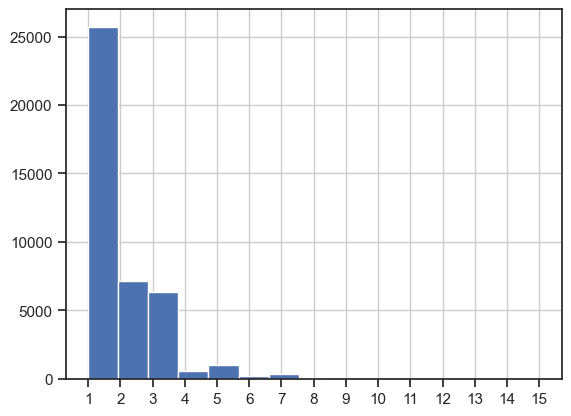

In [61]:
err_df['count_bucket'] = np.select(
    [
        err_df['cnt'].between(0, 1, inclusive=True),
        err_df['cnt'].between(2, 3, inclusive=True),
        err_df['cnt'].between(4, 10, inclusive=True),
        err_df['cnt'].between(11, 15, inclusive=True),
        err_df['cnt'].between(16, 50, inclusive=True),
        err_df['cnt'].between(51, 100, inclusive=True),
        err_df['cnt'].between(101, 1000, inclusive=True),
        err_df['cnt'].between(1001, 2000, inclusive=True),
        err_df['cnt'].between(2001, 3000, inclusive=True), 
        err_df['cnt'].between(3001, 4000, inclusive=True), 
        err_df['cnt'].between(4001, 5000, inclusive=True),
        err_df['cnt'].between(5001, 10000, inclusive=True),
        err_df['cnt'].between(10001, 20000, inclusive=True),
        err_df['cnt'].between(20001, 30000, inclusive=True)  
    ], 
    [
        1,2,3,4,5,6,7,8,9,10,11,12,13,14
    ], 
    default=15
)

# plot with adjusted labels
ax = err_df['count_bucket'].hist(bins=15,grid=True)
#ax.set_xlabel('Time (h)')
#ax.set_ylabel('Foo (Bar)')
ax.set_xticks(range(1,16))
#ax.set_xticklabels(labels)



### Wrting down hard files

In [62]:
difficult_to_parse_file_ids = no_leftovers['file_id'].unique().compute(scheduler='processes')

[########################################] | 100% Completed | 27.98 s


In [63]:
difficult_to_parse_file_ids.to_csv('jsqlparser_files_left_difficult_to_parse.csv',header=True,index=False)

In [64]:
no_leftovers.to_parquet('../out_new/jsqlparser_details_relevant_unparsed_errors_merged_sqlparser_hard_left_unparsed/',schema=not_parsed_schema,overwrite=True)

[########################################] | 100% Completed | 67.56 s
